<a href="https://colab.research.google.com/github/Lorenzo-Gardini/Computer-vision/blob/main/identity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identity

Questo progetto ha come obiettivo quello di realizzare un sistema di visione artificiale volto alla soluzione del gioco del cosiddetto "parente misterioso" che è parte del _game show_ "I soliti ignoti - Il ritorno" che va in onda su Rai Uno o, utilizzando il nome del _format_ televisivo originale, che è parte del _game show_ "Identity".

In questo gioco, al concorrente viene chiesto di osservare attentamente una persona, il "parente misterioso" appunto, e di raffrontare il suo volto con quello delle altre otto persone, gli "ignoti", con cui ha "giocato" per tutto il resto della trasmissione e che quindi ha già potuto vedere da vicino. Può chiedere alcuni aiuti, riducendo il montepremi finale che potrà portarsi a casa in caso di vittoria. Nel nostro problema, anche per semplificare le ipotesi del problema, al concorrente non viene fornito alcun indizio e deve scegliere perciò a colpo sicuro l'ignoto che è in relazione di parentela con il parente misterioso. In più, il tipo di parentela è uno dei primi indizi che viene fornito, ma nelle ipotesi di questo problema, dove gli indizi non sono forniti, si presuppone che debba essere indovinato dal concorrente, una volta scelto l'ignoto.

Il sistema creato dovrà perciò confrontare l'immagine del parente misterioso in coppia con ciascuno degli ignoti e determinare tra quale di questi c'è legame di parentela con il parente misterioso. Ci riferiremo a questo come "primo problema". Dopodiché, una volta accertata la parentela, il sistema deve classificare la coppia in una delle possibili relazioni di parentela, risolvendo il "secondo problema".

Questo progetto si ispira alla _competition_ "[Recognizing Faces in the Wild](https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/overview)" proposto dal "Northeastern SMILE Lab" sul sito "Kaggle", dove veniva richiesto di risolvere solamente quello che noi abbiamo definito "primo problema", quindi costruire un sistema che, dati due volti, capisse se fossero legati da parentela oppure no. Basarci su questa competition ci ha permesso di utilizzare lo stesso *dataset* per risolvere il problema, ovvero il "Families In the Wild" *dataset* che si trova a [questo link](https://web.northeastern.edu/smilelab/fiw/). In secondo luogo, ci ha permesso di ispirarci al lavoro fatto dal primo classificato, che ha riassunto lui stesso nelle [note da lui pubblicate](https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/discussion/103670). Ogni volta che è stato utilizzato l'apporto dei partecipanti alla *challenge* durante il corso di questo progetto, sarà esplicitamente indicato. Altrimenti, deve assumersi che il contributo è da intendersi come puramente nostro. Da ultimo, è stato possibile visionare la *leaderboard* e avere quindi un'idea generale della complessità del problema, capendo attorno a quale livello di accuratezza avremmo potuto attestarci.

Tutto il codice utilizzato, ma omesso perché non rilevante ai fini della trattazione, è possibile scaricarlo dal *repository* associato a questo *notebook* presente a [questo link](https://github.com/Lorenzo-Gardini/Computer-vision).

## Import iniziali

Per prima cosa installiamo le librerie che saranno utilizzate nel progetto non già disponibili di default nell'ambiente Colab. I moduli scaricati sono:

* "MTCNN": per utilizzare la rete omonima che permette di estrapolare i volti dalle immagini;
* "PyEFD": per poter estrarre gli "Elliptic Fourier Descriptors" di una forma;
* "XGBoost": per poter utilizzare il classificatore omonimo durante la classificazione di *feature handcrafted*;
* "Seaborn": per utilizzare l'omonima libreria per i grafici;
* "Keras Applications": per avere a disposizione modelli di reti profonde già addestrati e pronti per l'utilizzo;
* "Keras VGGFace": per poter utilizzare l'implementazione in Tensorflow e Keras dell'architettura "VGGFace".

In [ ]:
%%capture
!pip install mtcnn
!pip install pyefd
!pip install xgboost
!pip install seaborn
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

Dopodiché, scarichiamo e importiamo i moduli contenenti le funzioni e le classi di utilità usati in questo *notebook*. I moduli scaricati sono:

* "utils": contenente funzioni di utilità di vario genere;
* "classifier": contenente lo scheletro del sistema di classificazione che si baserà sui classificatori addestrati, ovvero quello per determinare l'esistenza della parentela e quello per determinare la specifica relazione, per "giocare" al gioco della trasmissione televisiva.

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/Lorenzo-Gardini/Computer-vision/main/utils.py
!wget https://raw.githubusercontent.com/Lorenzo-Gardini/Computer-vision/main/classifier.py

from utils import *
from classifier import Classifier

In seguito, scarichiamo e scompattiamo i *dataset* utilizzati in questo progetto. Sono presenti cinque cartelle:

* "test-public-faces": la cartella contenente i volti di *training*. È divisa in una sottocartella per ogni famiglia di persone, con nome che inizia per "F" seguito da quattro cifre, e ognuna di queste ha una sottocartella per ogni membro della famiglia. Ognuna di queste ultime ha nome che inizia per "MID" seguito da una cifra e contiene multiple immagini.
* "test-public-lists": la cartella contenente le etichette di *training*. Contiene un *file* "csv" per ogni tipo di relazione di parentela e ognuno di questi contiene diverse righe costituite da due dati. Il primo è il percorso di una cartella che indica il membro di una famiglia, il secondo un altro percorso di un altro membro della stessa famiglia. I nomi dei file sono:

  * "bb": contiene coppie di fratelli maschi;
  * "ss": contiene coppie di sorelle;
  * "sibs": contiene coppie fatte da un fratello maschio e una sorella;
  * "fs": contiene coppie fatte da padre e figlio;
  * "fd": contiene coppie fatte da padre e figlia;
  * "ms": contiene coppie fatte da madre e figlio;
  * "md": contiene coppie fatte da madre e figlia;
  * "gfgs": contiene coppie fatte da nonno e nipote maschio;
  * "gfgd": contiene coppie fatte da nonno e nipote femmina;
  * "gmgs": contiene coppie fatte da nonna e nipote maschio;
  * "gmgd": contiene coppie fatte da nonna e nipote femmina.

* "test-private-faces": la cartella contenente i volti di test. In questo caso i volti sono sparsi e numerati progressivamente;
* "test-private-lists": la cartella contenente le etichette di test. La struttura è analoga alla cartella contenente le etichette di training, che accoppia i volti in file diversi a seconda della relazione di parentela. La differenza è che, essendo da utilizzare per il test, non tutte le coppie sono veramente corrette;
* "test-private-labels": ha la stessa struttura di "test-private-list", ma per ogni coppia di immagini di ogni relazione di parentela indica se la relazione è vera o è falsa.

In [ ]:
%%capture
!wget https://github.com/Lorenzo-Gardini/Computer-vision/raw/main/datasets/test-public-faces.zip
!wget https://github.com/Lorenzo-Gardini/Computer-vision/raw/main/datasets/test-public-lists.zip
!wget https://github.com/Lorenzo-Gardini/Computer-vision/raw/main/datasets/test-private-faces.zip
!wget https://github.com/Lorenzo-Gardini/Computer-vision/raw/main/datasets/test-private-lists.zip
!wget https://github.com/Lorenzo-Gardini/Computer-vision/raw/main/datasets/test-private-labels.zip

unzip("test-public-faces.zip")
unzip("test-public-lists.zip")
unzip("test-private-faces.zip")
unzip("test-private-lists.zip")
unzip("test-private-labels.zip")

Scarichiamo il *dataset* di *training* riorganizzato in un formato più semplice per l'addestramento. Inoltre, vengono scaricati anche i file contenenti le etichette elaborate dai *dataset* originali che permettono di effettuare le associazioni tra le immagini riorganizzate e le diverse classi. La struttura delle etichette sarà argomento della prossima sezione. Le etichette combaciano con la struttura del *dataset* riordinato per quanto riguarda il *training set*, mentre invece comabaciano con quello originale per il *test set*.

In [ ]:
%%capture
!wget https://github.com/Lorenzo-Gardini/Computer-vision/raw/main/train-faces.zip
!wget https://github.com/Lorenzo-Gardini/Computer-vision/raw/main/labels.zip

unzip("train-faces.zip")
unzip("labels.zip")

Viene scaricato e decompresso anche il file che fa da *cache* per le *feature* *handcrafted* estratte per ogni immagine seguendo il procedimento che verrà descritto in seguito. Il come e il perché questo file è stato creato sono infatti oggetto di una sezione apposita di questo *notebook*.

In [ ]:
%%capture
!wget https://github.com/Lorenzo-Gardini/Computer-vision/raw/main/handcrafted.zip

unzip("handcrafted.zip")

Ultimo archivio a venire scaricato e decompresso è quello contenente le immagini delle puntate della trasmissione oggetto di questo progetto, sulle quali poi saranno testati i classificatori realizzati usando il sistema di classificazione complessivo.

In [ ]:
%%capture
!wget https://github.com/Lorenzo-Gardini/Computer-vision/raw/main/soliti_ignoti.zip

unzip("soliti_ignoti.zip")

Da ultimo, importiamo tutte le funzioni e le classi che servono al *notebook* per funzionare.

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from pyefd import elliptic_fourier_descriptors
from skimage.feature import local_binary_pattern
from skimage.color import deltaE_ciede2000
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from skopt import BayesSearchCV
from xgboost import XGBClassifier

## Descrizione dei dataset

### Immagini

Per quanto riguarda le immagini, come si può vedere sono prese da diverse angolazioni, in diverse condizioni di illuminazione, da camere diverse, a diverse risoluzioni e con un diverso numero di canali. Nonostante questo, sono tutte immagini già ritagliate per contenere unicamente la faccia della persona, il che significa che non è necessario doverla estrarre.

Train:


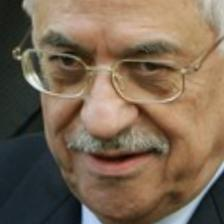

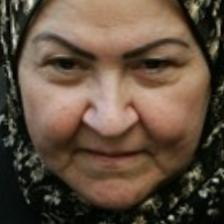

Test:


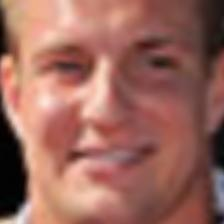

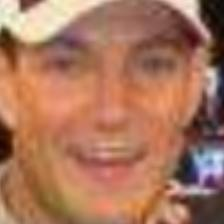

In [ ]:
print("Train:")
image_1 = load_image("train-faces/F0001_MID1_P00001_face2.jpg")
show_image(image_1)
image_2 = load_image("train-faces/F0001_MID2_P00001_face1.jpg")
show_image(image_2)
print("Test:")
image_3 = load_image("test-private-faces/face1.jpg")
show_image(image_3)
image_4 = load_image("test-private-faces/face2.jpg")
show_image(image_4)

Tutte le immagini hanno la stessa dimensione, ovvero 224 pixel per 224, e sono state caricate in memoria per essere a colori, perciò usano tre canali.

In [ ]:
print(image_1.shape)
print(image_2.shape)
print(image_3.shape)
print(image_4.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


### Etichette

Le informazioni utili estratte dalle etichette sono state raccolte in quattro *dataset*.

I primi due sono utili a risolvere il primo problema, quello sull'individuazione dell'esistenza della parentela o meno. Questi *dataset* devono quindi associare alle coppie di immagini una _label_ binaria, che è pari a 1 se c'è parentela tra le due immagini e 0 se non c'è. Dato che le informazioni che provengono dal *dataset* originale sono solamente su parentele realmente esistenti, non erano presenti casi negativi. Per poterli avere, si sono prese casualmente immagini dello stesso *dataset* che non erano accoppiate e sono state inserite in coda al *dataset* stesso, con label negativa. Tutte le coppie di immagini che invece erano già presenti, indipendentemente dalla relazione di parentela, sono state associate ad una label positiva. La generazione dei negativi è stata fatta in modo tale che le due classi abbiano lo stesso numero di istanze, per evitare sbilanciamenti.

Il *dataset* "train_binary" è quello estratto dalle etichette delle immagini di training, perciò i nomi delle immagini sono dati dal codice della famiglia, "underscore", codice del componente, "underscore" e infine il nome dell'immagine originale. Il *dataset* "test_binary" è invece quello estratto dalle etichette delle immagini di test, perciò i nomi delle immagini sono quelli originali. La scelta per il dataset di training di non avere più colonne, ma una sola che dà un nome univoco all'immagine, è per semplificare il salvataggio e l'ottenimento delle immagini stesse.

In [ ]:
train_binary = pd.read_csv("labels/train_binary.csv")
train_binary

p1                           p2  label
0       F0001_MID3_P00005_face2.jpg  F0001_MID4_P00005_face1.jpg      1
1       F0001_MID3_P00005_face2.jpg  F0001_MID4_P00006_face1.jpg      1
2       F0001_MID3_P00005_face2.jpg  F0001_MID4_P00007_face1.jpg      1
3       F0001_MID3_P00006_face2.jpg  F0001_MID4_P00005_face1.jpg      1
4       F0001_MID3_P00006_face2.jpg  F0001_MID4_P00006_face1.jpg      1
...                             ...                          ...    ...
554337  F0002_MID1_P00017_face3.jpg  F0468_MID3_P04939_face2.jpg      0
554338  F0002_MID1_P00017_face3.jpg  F0468_MID3_P04940_face1.jpg      0
554339  F0002_MID1_P00017_face3.jpg  F0469_MID1_P04942_face2.jpg      0
554340  F0002_MID1_P00017_face3.jpg  F0469_MID1_P04943_face2.jpg      0
554341  F0002_MID1_P00017_face3.jpg  F0469_MID1_P04945_face1.jpg      0

[554342 rows x 3 columns]

In [ ]:
test_binary = pd.read_csv("labels/test_binary.csv")
test_binary

p1            p2  label
0      face3986.jpg  face3993.jpg      1
1      face3986.jpg  face3988.jpg      1
2      face3984.jpg  face3988.jpg      1
3      face3988.jpg  face3993.jpg      1
4      face3984.jpg  face3993.jpg      1
...             ...           ...    ...
99957  face1923.jpg   face748.jpg      0
99958  face3564.jpg  face1642.jpg      0
99959  face1925.jpg  face1645.jpg      0
99960  face3582.jpg  face3952.jpg      0
99961  face1599.jpg  face3571.jpg      0

[99962 rows x 3 columns]

Si è deciso di utilizzare "label encoding" per codificare le undici classi di parentela che sono parte di questo progetto. Le associazioni costituiscono il dizionario Python qui di seguito.

In [ ]:
with open("labels/class_encoding.json") as f:
  classes = json.load(f)
classes

{'bb': 0,
 'fd': 1,
 'fs': 2,
 'gfgd': 3,
 'gfgs': 4,
 'gmgd': 5,
 'gmgs': 6,
 'md': 7,
 'ms': 8,
 'sibs': 9,
 'ss': 10}

Gli ultimi due *dataset* sono quelli inerenti al secondo problema, ovvero quello di stabilire per una coppia di immagini che rappresentano due persone sicuramente imparentate tra di loro, che tipo di relazione hanno. La struttura dei due *dataset* è analoga a quella dei precedenti, cambia solamente il contenuto in termini di istanze e la colonna "label". In questo caso infatti sono presenti solamente i casi positivi dei precedenti due dataset, perciò la loro dimensione è la metà dei precedenti in termini di istanze. L'etichetta però indica in questo caso il tipo di relazione tra le classi e perciò ha un valore che va da 0 a 10, in accordo al dizionario precedentemente mostrato.

In [ ]:
train_multiclass = pd.read_csv("labels/train_multiclass.csv")
train_multiclass

p1                           p2  relation
0       F0001_MID3_P00005_face2.jpg  F0001_MID4_P00005_face1.jpg         0
1       F0001_MID3_P00005_face2.jpg  F0001_MID4_P00006_face1.jpg         0
2       F0001_MID3_P00005_face2.jpg  F0001_MID4_P00007_face1.jpg         0
3       F0001_MID3_P00006_face2.jpg  F0001_MID4_P00005_face1.jpg         0
4       F0001_MID3_P00006_face2.jpg  F0001_MID4_P00006_face1.jpg         0
...                             ...                          ...       ...
277166  F0996_MID1_P10522_face1.jpg  F0996_MID2_P10522_face2.jpg        10
277167  F0996_MID1_P10522_face1.jpg  F0996_MID2_P10529_face2.jpg        10
277168  F0996_MID1_P10529_face1.jpg  F0996_MID2_P10516_face2.jpg        10
277169  F0996_MID1_P10529_face1.jpg  F0996_MID2_P10522_face2.jpg        10
277170  F0996_MID1_P10529_face1.jpg  F0996_MID2_P10529_face2.jpg        10

[277171 rows x 3 columns]

In [ ]:
test_multiclass = pd.read_csv("labels/test_multiclass.csv")
test_multiclass

p1            p2  relation
0      face3986.jpg  face3993.jpg         0
1      face3986.jpg  face3988.jpg         0
2      face3984.jpg  face3988.jpg         0
3      face3988.jpg  face3993.jpg         0
4      face3984.jpg  face3993.jpg         0
...             ...           ...       ...
49976  face2421.jpg  face2411.jpg        10
49977  face2413.jpg  face2411.jpg        10
49978  face2414.jpg  face2411.jpg        10
49979  face2412.jpg  face2411.jpg        10
49980  face2422.jpg  face2411.jpg        10

[49981 rows x 3 columns]

## Analisi dei dataset

Come si può notare, non tutte le classi hanno lo stesso peso. La classe più presente di tutti è la coppia "padre - figlio", seguita da quella "madre - figlio" con 6.000 istanze in meno, che a sua volta è seguita da coppie di fratelli maschi con ulteriori 6.000 istanze in meno. Solo 4.000 istanze separano questa da quella "padre - figlia", così come da questa a quella "madre - figlia". Ultima classe fortemente rappresentata è quella di coppie di fratelli di genere distinto, con solo 3.000 istanze in meno rispetto alla precedente. Ci aspettiamo perciò che per quanto riguarda le classi elencate, un eventuale classificatore faccia meno fatica a identificarle correttamente, non solo per la distanza di età più ridotta. Ci sono comunque circa 23.000 istanze di differenza tra la prima e l'ultima classe citate. Molto meno rappresentate sono le classi di sorelle, solo 17.000 istanze, e qielle che riguardano i nonni e i nipoti, che oscillano tra le 3.000 e le 1.500 istanze l'una.

In [ ]:
counts = train_multiclass["relation"].value_counts().rename({v: k for (k, v) in classes.items()})
counts

fs      54848
ms      48779
bb      42679
fd      38421
md      34061
sibs    31726
ss      17600
gfgd     3162
gmgd     2674
gfgs     1657
gmgs     1564
Name: relation, dtype: int64

Raggruppando le classi per super-tipologie di relazione di parentela, si nota come quella che associa genitori con figli è quella di gran lunga più rappresentata, quasi il doppio di quella immediatamente successiva che è quella che associa tra loro i fratelli. La classe che relaziona i nonni con i loro nipoti ha numeri trascurabili in confronto alle altre due, poco meno di un decimo di quella immediatamente precedente. Ci aspettiamo quindi che le prime due tipologie di relazioni siano facilmente individuate dalla rete, mentre l'ultima sia molto più difficile da distinguere.

In [ ]:
supercounts = pd.Series(
    [
        counts["fs"] + counts["ms"] + counts["fd"] + counts["md"],
        counts["bb"] + counts["ss"] + counts["sibs"],
        counts["gfgd"] + counts["gfgs"] + counts["gmgd"] + counts["gmgs"]
    ],
    ["parents - children", "siblings", "grandparents - grandchildren"]
)
supercounts

parents - children              176109
siblings                         92005
grandparents - grandchildren      9057
dtype: int64

C'è anche uno sbilanciamento tra i generi: gli uomini sono presenti nel dataset in circa 100.000 immagini in più rispetto alle donne. Questo significa che le relazioni tra uomini saranno più facili da individuare rispetto a quelle tra donne.

In [ ]:
genders = pd.Series(
    [
        2 * counts["fs"] + counts["ms"] + counts["fd"] + 2 * counts["bb"] + counts["sibs"] + counts["gfgd"] + 2 * counts["gfgs"] + counts["gmgs"],
        2 * counts["md"] + counts["ms"] + counts["fd"] + 2 * + counts["ss"] + counts["sibs"] + counts["gfgd"] + 2 * counts["gmgd"] + counts["gmgs"],
    ],
    ["males", "females"]
)
genders

males      322020
females    232322
dtype: int64

## Preprocessing dei dataset

Prima di effettuare l'estrazione delle *feature* di interesse, si è cercato di correggere le eventuali variazioni che possono intercorrere tra le diverse immagini. Come già detto, infatti, le immagini sono state catturate da camere diverse, a diverse angolazioni, in diverse condizioni di illuminazione, a risoluzioni diverse e con un numero diverso di canali.
Molte di queste differenze non possono essere rimosse, però si è cercato di mitigare la diversità nel numero di canali e di illuminazione. La prima, trattenendo solamente le immagini a colori ed eliminando quelle in *grayscale*, visto che si dovrà estrarre successivamente delle *feature* sui colori dell'immagine. La seconda, attraverso una correzione di gamma.

Carichiamo perciò le immagini di *training* e di test dalle rispettive cartelle ed andiamo a trattenere solamente quelle che hanno almeno un pixel il cui valore di luminosità per un canale differisce dagli altri due nella stessa posizione. Nello spazio colore "BGR", infatti, i grigi si ottengono reduplicando gli stessi valori di luminosità su tutti e tre i canali "blu", "verde" e "rosso". Se un'immagine possiede almeno un pixel con un valore di luminosità differente per uno dei canali, allora l'immagine non è più *grayscale*.

In [ ]:
def remove_grayscale_images(images_directory):
  color_images = {}
  images = os.listdir(images_directory)
  images.sort()
  for image_path in images:
    image = load_image(f"{images_directory}/{image_path}")
    b, g, r = cv.split(image)
    if (b != g).sum() != 0 and (g != r).sum() != 0:
      color_images[image_path] = image
  return color_images

images_train = remove_grayscale_images("train-faces")
images_test = remove_grayscale_images("test-private-faces")

Così facendo, delle 20.700 immagini del *training set* ne rimangono solamente 19.000 circa e delle 5.000 del *test set* ne rimangono solamente 4.600.

In [ ]:
images_train_path = os.listdir("train-faces")
images_test_path = os.listdir("test-private-faces")
print(f"Original train images: {len(images_train_path)}, color train images: {len(images_train)}")
print(f"Original train images: {len(images_test_path)}, color train images: {len(images_test)}")

Original train images: 20726, color train images: 19077
Original train images: 4949, color train images: 4604


A questo punto, per cercare di correggere le variazioni di illuminazione delle immagini, scegliamo innanzitutto cinque immagini in maniera casuale per osservare gli effetti della correzione di gamma che vogliamo applicare.

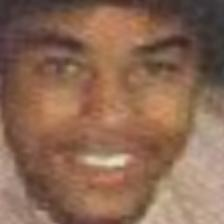

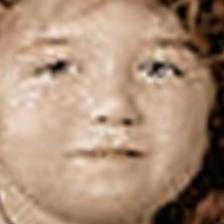

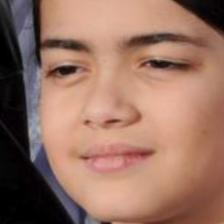

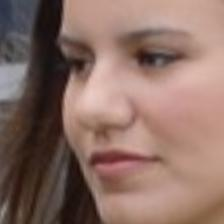

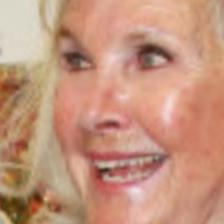

In [ ]:
generator = np.random.default_rng(1234)
images = generator.choice(list(images_train.values()), size=(5,), replace=False, shuffle=False)
for image in images:
  show_image(image)

La correzione di gamma è l'applicazione di una funzione non lineare a tutti i pixel dell'immagine, che si preoccupa di equalizzare i diversi valori di luminosità. Questa dipende infatti da un parametro omonimo per cui, se $\gamma > 1$, i toni più chiari sono scuriti, mentre se $\gamma < 1$, i toni più scuri vengono schiariti.

L'idea è identificare automaticamente per ciascuna immagine il valore del parametro e la scelta è ricaduta su di un metodo utilizzato anche in alcuni software di *photoediting*. Questa tecnica consiste nel calcolare gamma come il rapporto del logaritmo della media della luminosità di tutti i pixel fratto il logaritmo di 128. In questo modo, nell'immagine la luminosità media apparirà come 50% luminosa e tutte le altre saranno tarate in conseguenza.

Poiché i pixel sono nello spazio colore BGR, viene prima fatta una conversione nello spazio HSV, corretto il canale inerente alla luminosità, ovvero "Value", e poi riconvertite in BGR.

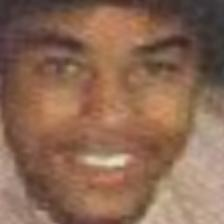

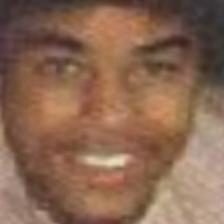

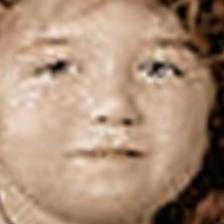

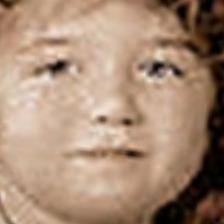

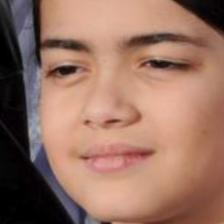

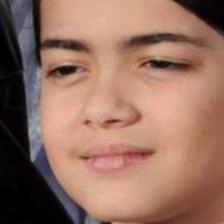

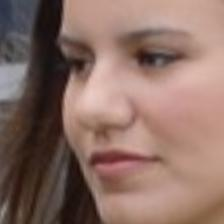

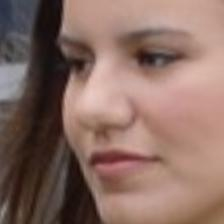

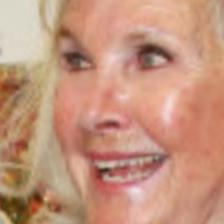

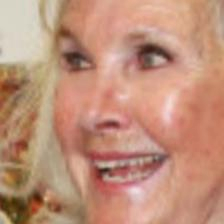

In [ ]:
for image in images:
  hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
  h, s, v = cv.split(hsv_image)
  gamma = np.log(v.mean()) / np.log(128)
  corrected_v = (255 * ((v / 255) ** gamma)).astype(np.uint8)
  corrected = cv.cvtColor(np.dstack([h, s, corrected_v]), cv.COLOR_HSV2BGR)
  show_image(image)
  show_image(corrected)
  print()

Applichiamo quindi la correzione di gamma a tutte le immagini, sia del *train set* che del *test set*.

In [ ]:
def correct_gamma(image):
  hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
  h, s, v = cv.split(hsv_image)
  gamma = np.log(v.mean()) / np.log(128)
  corrected_v = (255 * ((v / 255) ** gamma)).astype(np.uint8)
  return cv.cvtColor(np.dstack([h, s, corrected_v]), cv.COLOR_HSV2BGR)

images_train = {path: correct_gamma(image) for path, image in images_train.items()}
images_test = {path: correct_gamma(image) for path, image in images_test.items()}

## Estrazione di feature handcrafted

Si è deciso di basare l'estrazione delle feature *handcrafted* sul procedimento che utilizzano gli esseri umani stessi per riconoscere un volto e, perciò, per associare due persone attraverso il loro legame di parentela. Gli elementi su cui tutti noi ci focalizziamo per analizzare un volto sono il colore della pelle, il colore e la forma degli occhi, la forma delle sopracciglia, la forma del naso, la forma della bocca e la *texture* del viso.

L'estrazione di ciascuna tipologia di feature viene esemplificata sulle cinque immagini scelte casualmente in precedenza.

### Forma del naso

Per quanto riguarda il naso, la feature più interessante è certamente la sua forma. Anche in questo caso, la prima cosa che è stato necessario fare è quella di individuare la parte dell'immagine che la contiene.
Il naso si trova sempre tra gli occhi, limitato dagli estremi di questi a destra e a sinistra, perciò rispetto alla posizione di questi ultimi sono stati aggiunti o rimossi tanti pixel quanti ne conta il semiasse maggiore dell'ellisse che modella l'occhio. L'estremo superiore della bounding box è sempre la linea degli occhi, mentre invece l'estremo inferiore deve cadere tra la bocca e il naso, quindi all'incirca ai 15/24 dell'altezza dell'immagine.

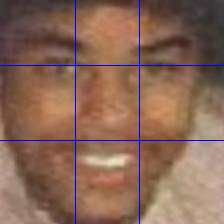

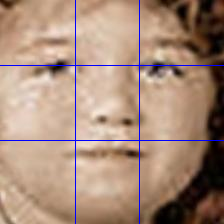

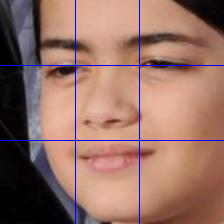

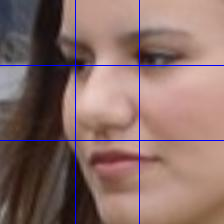

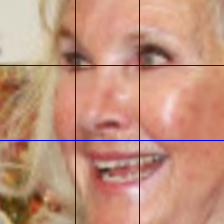

In [ ]:
for image in images:
  image_lines = image.copy()
  lines = [
      (  # eye line
          (0, image_lines.shape[0] * 7 // 24),
          (image_lines.shape[1], image_lines.shape[0] * 7 // 24)
      ),
      (  # left eye right extremity
          (image_lines.shape[1] * 7 // 24 + 10, 0),
          (image_lines.shape[1] * 7 // 24 + 10, image_lines.shape[0])
      ),
      (  # right eye left extremity
          (image_lines.shape[1] * 2 // 3 - 10, 0),
          (image_lines.shape[1] * 2 // 3 - 10, image_lines.shape[0])
      ),
      (  # inbetween line
          (0, image_lines.shape[0] * 15 // 24),
          (image_lines.shape[1], image_lines.shape[0] * 15 // 24)
      )
  ]
  for line in lines:
      cv.line(
          image_lines,
          line[0],
          line[1],
          (255, 0, 0),
          1
      )
  show_image(image_lines)

Disegnamo poi un rettangolo attorno al naso, per poterlo ritagliare e concentrarci sull'estrazione solo della sua forma.

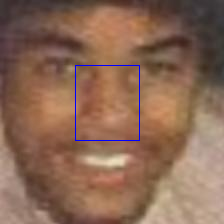

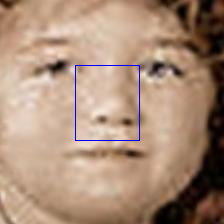

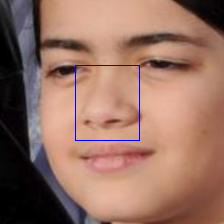

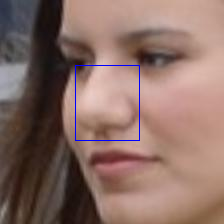

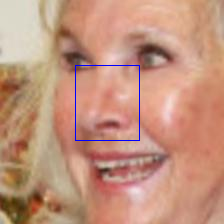

In [ ]:
for image in images:
  image_lines = image.copy()
  cv.rectangle(
    image_lines,
    (image_lines.shape[1] * 7 // 24 + 10, image_lines.shape[0] * 7 // 24),
    (image_lines.shape[1] * 2 // 3 - 10, image_lines.shape[0] * 15 // 24),
    (255, 0, 0),
    1
  )
  show_image(image_lines)

Per estrarre la forma del naso, prima di tutto si converte l'immagine in *grayscale*, poi la si ritaglia all'altezza del naso come già detto e in seguito si applica un filtro per la riduzione del rumore, ovvero un filtro di *blur* gaussiano. Il filtro deve essere particolarmente grande, quindi forte, perché il processo di isteresi del "Canny edge detector" utilizzato subito dopo dovrà utilizzare dei valori molto bassi. Questo perché le variazioni di luminosità che indicano i contorni del naso sono molto ridotte. È stato trovato che con un filtro di dimensioni 3x9 e sigma 0 i risultati sono migliori, perché i bordi orizzontali sono facili da individuare, mentre quelli verticali si perdono facilmente. I valori per il Canny edge detector che si sono rivelati migliori sono 15 e 30 e si è utilizzato il gradiente più raffinato data la complessità di estrazione dei bordi.

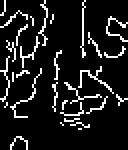

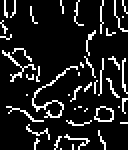

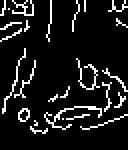

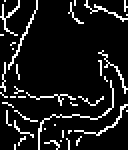

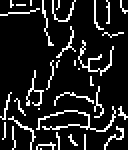

In [ ]:
cannys = []
for image in images:
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image_cropped = image_gray[
    (image_gray.shape[0] * 7 // 24):(image_gray.shape[0] * 15 // 24),
    (image_gray.shape[1] * 7 // 24 + 10):(image_gray.shape[1] * 2 // 3 - 10)
  ]
  image_blurred = cv.GaussianBlur(image_cropped, (3, 9), 0)
  canny = cv.Canny(image_blurred, 15, 30, L2gradient=True)
  cannys.append(canny)
  show_image(cv.resize(canny, None, None, 2, 2, cv.INTER_NEAREST))
  print()

Per migliorare l'immagine binaria ottenuta, si è ricorso ad una serie di operazioni di morfologia matematica per colmare le lacune tra i bordi ed ottenere perciò un contorno unico. Si è operata prima un'operazione di chiusura per colmare le lacune che si trovano tra i frammenti di bordo, anche molto grandi a causa della difficoltà riscontrata dall'operazione di edge detection. Si è infatti adoperato un elemento strutturante 7x7 ellissoidale, in modo che i contorni avessero un aspetto più naturale. Dopodiché, si è effettuata un'operazione di dilatazione dei contorni per congiungerli tra di loro, seguita da una di erosione per riportarli al loro spessore originale. L'elemento strutturante utilizzato in questo caso, per entrambe le operazioni, è un ellisse 3x3.

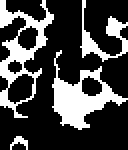

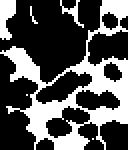

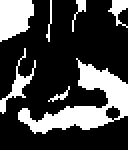

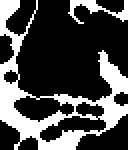

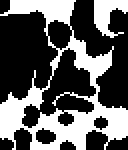

In [ ]:
morphed = []

for image in cannys:
  elem_1 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
  closed = cv.morphologyEx(image, cv.MORPH_CLOSE, elem_1)
  elem_2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
  dilated = cv.morphologyEx(closed, cv.MORPH_DILATE, elem_2)
  eroded = cv.morphologyEx(dilated, cv.MORPH_ERODE, elem_2)
  morphed.append(eroded)
  show_image(cv.resize(eroded, None, None, 2, 2, cv.INTER_NEAREST))
  print()

Una volta ottenuti i contorni del naso finali, è stato possibile estrarre le feature di interesse.

Innanzitutto sono stati eliminati i bordi ancora non connessi, che a questo punto possiamo considerare come non appartenenti al naso. Questo è stato fatto attraverso l'operazione di etichettatura delle componenti connesse, andando a tenere solamente quella con area, cioè numero di pixel, maggiore.

Dopodiché si sono estratte le coordinate del centroide, nonché, sapendo le dimensioni della bounding box, l'elongazione. Si è calcolato il *convex hull* e con questo si è ottenuta la convessità della forma del naso. Queste informazioni sono utili per capire la lunghezza del naso, se è più lungo o più corto, nonché la sua tipologia, ovvero se è più "aquilino" o "schiacciato".

Infine, per non perdere completamente tutte le informazioni sulla forma del naso, si è ricorso ad un indicatore più complesso come i descrittori ellittici di Fourier. Questi descrittori costruiscono un'approssimazione dei contorni mediante una somma di ellissi ruotate o allungate in diversi modi. Queste ellissi sono estratte dalla trasformata di Fourier discreta del contorno, codificato sotto forma di segmenti lineari. Come spiegato nell'articolo originale di Kuhl e Giardina, "[Elliptic Fourier features of a closed contour](https://doi.org/10.1016/0146-664X(82)90034-X)", questi descrittori sono invarianti per rotazione, scala e traslazione e sono molto compatti, dato che un ellisse utilizza solamente 4 parametri. In questo modo, è possibile utilizzare fino a 64 curve per approssimare il contorno senza generare troppe *feature*.

L'estrazione delle feature tramite "shape matrix" è stata ritenuta troppo semplice in confronto a descrittori così avanzati come gli E.F.D. a parità di numero di valori. Indicatori come "Beam Angle Statistics" e i descrittori di Fourier semplici soffrono del problema di non poter essere estratti in numero fisso. Questo significa che o è necessario aggiungere del "padding" alla sequenza dei punti che compongono il contorno o occorre campionarlo per arrivare al numero desiderato di punti. Entrambe le operazioni, che vanno ad introdurre errore nella rappresentazione, non sono affatto desiderabili. Solamente i descrittori di Fourier, essendo coefficienti di serie di Fourier, possono essere troncati dopo essere stati calcolati ottenendo ancora un risultato valido, ma approssimato. Rimane irrisolto però il problema del padding. L'utilizzo degli E.F.D. risulta perciò più semplice a parità di informazioni estratte.

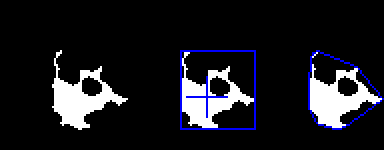

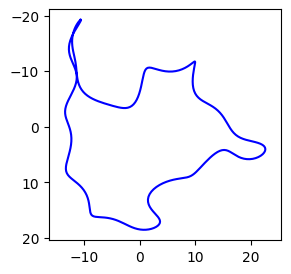


elongation:-0.05263157894736836, convexity:0.7093134412301617



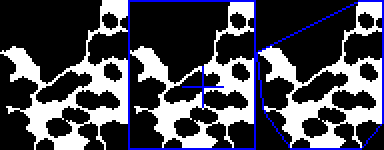

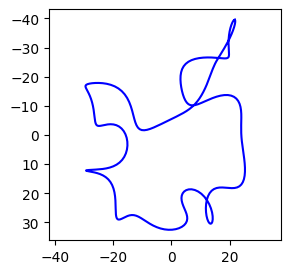


elongation:-0.171875, convexity:0.5502981564198302



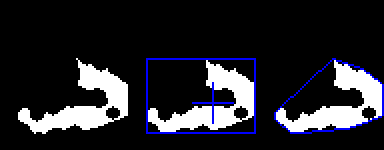

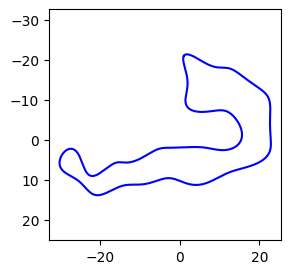


elongation:0.3090909090909091, convexity:0.6822317314733137



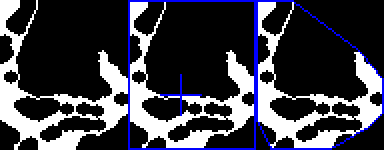

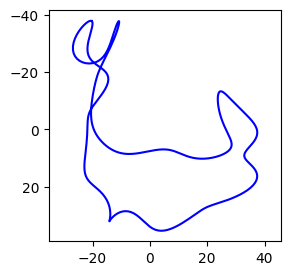


elongation:-0.171875, convexity:0.5686514987254719



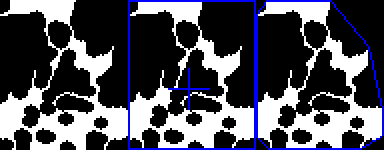

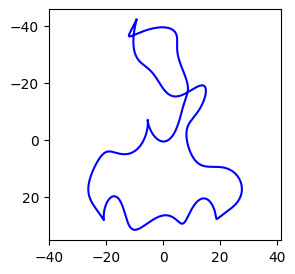


elongation:-0.171875, convexity:0.5900304201842625



In [ ]:
for image in morphed:
  (num_labels, labels, stats, centroids) = cv.connectedComponentsWithStats(image)

  if num_labels == 1:
    print("Nose not found")
    break

  biggest_cc = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

  centroid = centroids[biggest_cc]
  elongation = 1 - stats[biggest_cc, cv.CC_STAT_HEIGHT] / stats[biggest_cc, cv.CC_STAT_WIDTH]

  shape = np.array((labels == biggest_cc) * 255, dtype=np.uint8)
  contours, _ = cv.findContours(shape, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  convex_hull = cv.convexHull(contours[0])
  convexity = cv.arcLength(convex_hull, True) / cv.arcLength(contours[0], True)

  elliptic_coeffs = elliptic_fourier_descriptors(np.squeeze(contours[0]), order=16)

  shape_with_bb = cv.rectangle(
    np.stack([shape, shape, shape], axis=2),
    (stats[biggest_cc, cv.CC_STAT_LEFT], stats[biggest_cc, cv.CC_STAT_TOP]),
    (
      stats[biggest_cc, cv.CC_STAT_LEFT] + stats[biggest_cc, cv.CC_STAT_WIDTH] - 1,
      stats[biggest_cc, cv.CC_STAT_TOP] + stats[biggest_cc, cv.CC_STAT_HEIGHT] - 1
    ),
    (255, 0, 0),
    1
  )
  shape_with_bb = cv.drawMarker(
    shape_with_bb,
    (int(centroid[0]), int(centroid[1])),
    (255, 0, 0),
    cv.MARKER_CROSS
  )

  shape_with_ch = cv.drawContours(
    np.stack([shape, shape, shape], axis=2),
    [convex_hull],
    0,
    (255, 0, 0),
    1
  )

  show_image(cv.resize(
    np.hstack([np.dstack([shape, shape, shape]), shape_with_bb, shape_with_ch]),
    None,
    None,
    2,
    2,
    cv.INTER_NEAREST
  ))
  print()
  t = np.linspace(0, 1.0, 300)
  xt = np.zeros((300,))
  yt = np.zeros((300,))
  for n in range(elliptic_coeffs.shape[0]):
    xt += (elliptic_coeffs[n, 0] * np.cos(2 * (n + 1) * np.pi * t)) + (
      elliptic_coeffs[n, 1] * np.sin(2 * (n + 1) * np.pi * t)
    )
    yt += (elliptic_coeffs[n, 2] * np.cos(2 * (n + 1) * np.pi * t)) + (
      elliptic_coeffs[n, 3] * np.sin(2 * (n + 1) * np.pi * t)
    )
  plt.figure(figsize=(3, 3))
  plt.plot(xt, yt, "b")
  plt.gca().invert_yaxis()
  plt.axis("equal")
  plt.show()
  print(f"\nelongation:{elongation}, convexity:{convexity}\n")

In questo modo, si è determinato il processo di estrazione della forma del naso da un'immagine. Nel caso in cui non venga trovata neanche una componente connessa, cioè l'immagine trasformata non contenga nessun potenziale contorno del naso, semplicemente viene restituito un valore di speciale, che farà scartare l'immagine. Le posizioni dei centroidi sono normalizzate dividendole per le dimensioni dell'immagine.

In [ ]:
def extract_nose_shape(image):
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image_cropped = image_gray[
    (image_gray.shape[0] * 7 // 24):(image_gray.shape[0] * 7 // 12),
    (image_gray.shape[1] * 7 // 24 + 10):(image_gray.shape[1] * 2 // 3 - 10)
  ]
  image_blurred = cv.GaussianBlur(image_cropped, (3, 9), 0)
  canny = cv.Canny(image_blurred, 15, 30, L2gradient=True)
  elem_1 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
  closed = cv.morphologyEx(canny, cv.MORPH_CLOSE, elem_1)
  elem_2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
  dilated = cv.morphologyEx(closed, cv.MORPH_DILATE, elem_2)
  eroded = cv.morphologyEx(dilated, cv.MORPH_ERODE, elem_2)
  (num_labels, labels, stats, centroids) = cv.connectedComponentsWithStats(eroded)

  if num_labels == 1:
    return None

  biggest_cc = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

  centroid = centroids[biggest_cc]
  elongation = 1 - stats[biggest_cc, cv.CC_STAT_HEIGHT] / stats[biggest_cc, cv.CC_STAT_WIDTH]

  shape = np.array((labels == biggest_cc) * 255, dtype=np.uint8)
  contours, _ = cv.findContours(shape, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  convex_hull = cv.convexHull(contours[0])
  convexity = cv.arcLength(contours[0], False) / cv.arcLength(convex_hull, True)

  elliptic_coeffs = elliptic_fourier_descriptors(np.squeeze(contours[0]), order=16, normalize=True).flatten()[3:]

  return np.concatenate([
    [centroid[0] / image.shape[1], centroid[1] / image.shape[0], elongation, convexity],
    elliptic_coeffs
  ], axis=None)

### Forma della bocca

Il processo di estrazione della forma della bocca è analogo a quello per la forma del naso, in quanto il metodo per identificare i contorni è sempre lo stesso. Naturalmente, la parte dell'immagine coinvolta come i parametri dei diversi passi che compongono il processo sono differenti, ma i concetti rimangono sempre gli stessi.

In un volto, la bocca è sempre posizionata al di sotto del naso. Per questo motivo, l'estremo superiore del rettangolo che la contiene è delimitato dalla linea che in precedenza è stata utilizzata per indicare la fine della zona del naso. Poiché la bocca è molto lunga e le sue estremità si trovano sotto gli occhi, ma non completamente, per identificare i suoi limiti sono state utilizzare le posizioni degli occhi, a cui sono stati sottratti a sinistra e aggiunti a destra i 3/2 del semiasse maggiore dell'ellisse che contiene gli stessi. Si è inoltre determinato che la posizione migliore per delimitare inferiormente la zona della bocca è ai 7/8 dell'immagine.

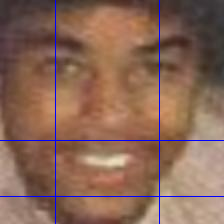

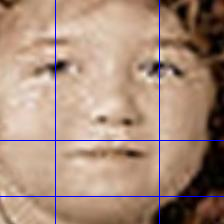

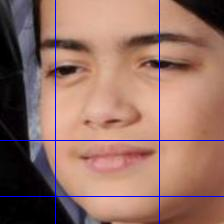

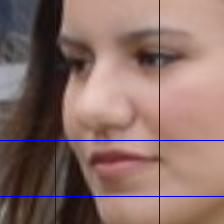

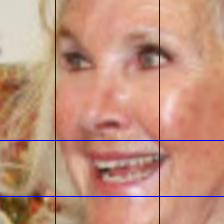

In [ ]:
for image in images:
  image_lines = image.copy()
  lines = [
      (  # left eye left extremity
          (image_lines.shape[1] * 7 // 24 - 10, 0),
          (image_lines.shape[1] * 7 // 24 - 10, image_lines.shape[0])
      ),
      (  # right eye
          (image_lines.shape[1] * 2 // 3 + 10, 0),
          (image_lines.shape[1] * 2 // 3 + 10, image_lines.shape[0])
      ),
      (  # inbetween line
          (0, image_lines.shape[0] * 15 // 24),
          (image_lines.shape[1], image_lines.shape[0] * 15 // 24)
      ),
      (  # under mouth line
          (0, image_lines.shape[0] * 7 // 8),
          (image_lines.shape[1], image_lines.shape[0] * 7 // 8)
      )
  ]
  for line in lines:
      cv.line(
          image_lines,
          line[0],
          line[1],
          (255, 0, 0),
          1
      )
  show_image(image_lines)

Come già fatto in precedenza, si è poi disegnato un rettangolo attorno alla bocca con le linee poc'anzi definite per poterla poi ritagliare dall'immagine.

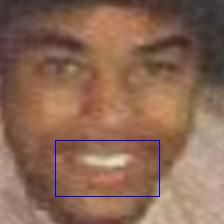

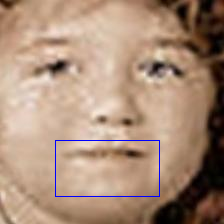

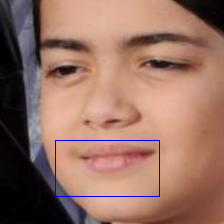

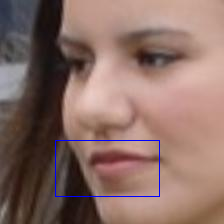

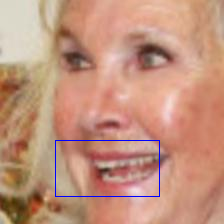

In [ ]:
for image in images:
  image_lines = image.copy()
  cv.rectangle(
    image_lines,
    (image_lines.shape[1] * 7 // 24 - 10, image_lines.shape[0] * 15 // 24),
    (image_lines.shape[1] * 2 // 3 + 10, image_lines.shape[0] * 7 // 8),
    (255, 0, 0),
    1
  )
  show_image(image_lines)

Con l'utilizzo del "Canny edge detector" sono stati estrapolati i bordi della bocca dall'area dell'immagine identificata in precedenza. Sull'area è statp prima applicato un filtro gaussiano 3x3 con sigma 0, poi il *detector* effettivo. Le soglie di isteresi che si sono rivelate migliori sono state 40 e 60 e anche in questo caso si è ricorso al gradiente più preciso.

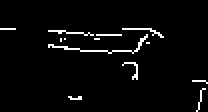

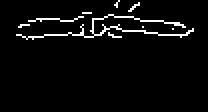

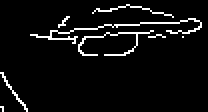

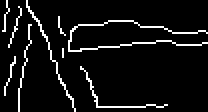

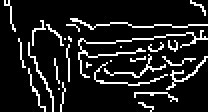

In [ ]:
cannys = []
for image in images:
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image_cropped = image_gray[
    (image_gray.shape[0] * 15 // 24):(image_gray.shape[0] * 7 // 8),
    (image_gray.shape[1] * 7 // 24 - 10):(image_gray.shape[1] * 2 // 3 + 10)
  ]
  image_blurred = cv.GaussianBlur(image_cropped, (3, 3), 0)
  canny = cv.Canny(image_blurred, 40, 60, L2gradient=True)
  cannys.append(canny)
  show_image(cv.resize(canny, None, None, 2, 2, cv.INTER_NEAREST))
  print()

Si sono applicate le stesse operazioni di chiusura, dilatazione ed erosione che in precedenza. In questo caso per tutte le operazioni si è usato un elemento strutturante ellissoidale 7x7.

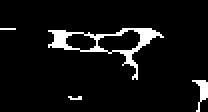

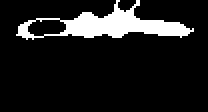

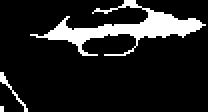

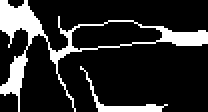

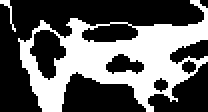

In [ ]:
morphed = []

for image in cannys:
  elem = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
  closed = cv.morphologyEx(image, cv.MORPH_CLOSE, elem)
  dilated = cv.morphologyEx(closed, cv.MORPH_DILATE, elem)
  eroded = cv.morphologyEx(dilated, cv.MORPH_ERODE, elem)
  morphed.append(eroded)
  show_image(cv.resize(eroded, None, None, 2, 2, cv.INTER_NEAREST))
  print()

Da ultimo, sono state eliminate tutte le componenti connesse che non erano la più grande e poi, su questa, sono stati calcolati il centroide e l'elongazione. Calcolati i contorni è stato poi possibile calcolare il *convex hull* e quindi la convessità. Per catturare anche informazioni più complesse, sono stati calcolati i descrittori ellittici di Fourier di grado 16.

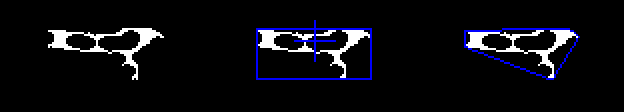

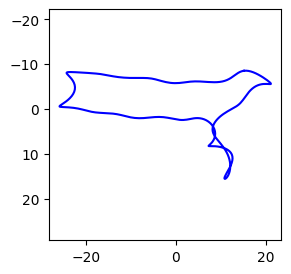


elongation:0.5517241379310345, convexity:0.7960731454980924



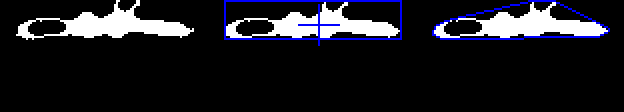

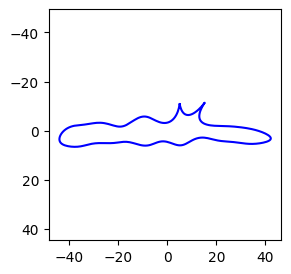


elongation:0.7752808988764045, convexity:0.8303481943055562



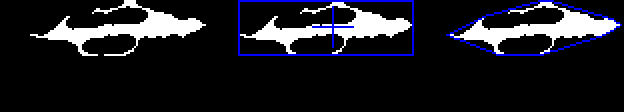

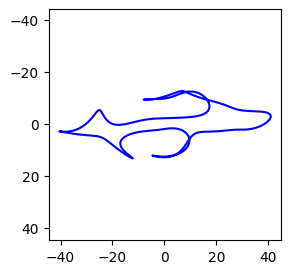


elongation:0.6818181818181819, convexity:0.5411948221264414



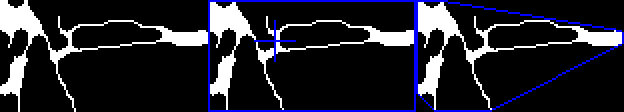

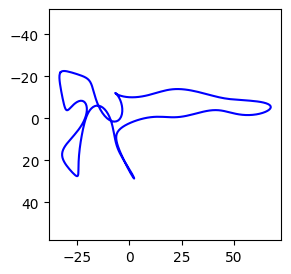


elongation:0.46153846153846156, convexity:0.5780551742433538



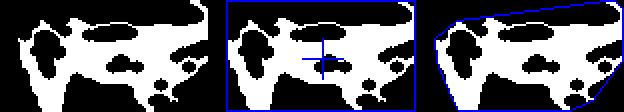

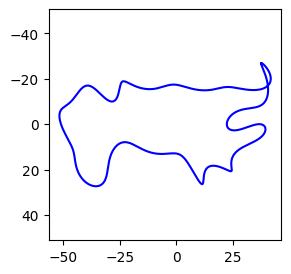


elongation:0.41052631578947374, convexity:0.6489056521190995



In [ ]:
for image in morphed:
  (num_labels, labels, stats, centroids) = cv.connectedComponentsWithStats(image)

  if num_labels == 1:
    print("Mouth not found")
    break

  biggest_cc = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

  centroid = centroids[biggest_cc]
  elongation = 1 - stats[biggest_cc, cv.CC_STAT_HEIGHT] / stats[biggest_cc, cv.CC_STAT_WIDTH]

  shape = np.array((labels == biggest_cc) * 255, dtype=np.uint8)
  contours, _ = cv.findContours(shape, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  convex_hull = cv.convexHull(contours[0])
  convexity = cv.arcLength(convex_hull, True) / cv.arcLength(contours[0], True)

  elliptic_coeffs = elliptic_fourier_descriptors(np.squeeze(contours[0]), order=16)

  shape_with_bb = cv.rectangle(
    np.stack([shape, shape, shape], axis=2),
    (stats[biggest_cc, cv.CC_STAT_LEFT], stats[biggest_cc, cv.CC_STAT_TOP]),
    (
      stats[biggest_cc, cv.CC_STAT_LEFT] + stats[biggest_cc, cv.CC_STAT_WIDTH] - 1,
      stats[biggest_cc, cv.CC_STAT_TOP] + stats[biggest_cc, cv.CC_STAT_HEIGHT] - 1
    ),
    (255, 0, 0),
    1
  )
  shape_with_bb = cv.drawMarker(
    shape_with_bb,
    (int(centroid[0]), int(centroid[1])),
    (255, 0, 0),
    cv.MARKER_CROSS
  )

  shape_with_ch = cv.drawContours(
    np.stack([shape, shape, shape], axis=2),
    [convex_hull],
    0,
    (255, 0, 0),
    1
  )

  show_image(cv.resize(
    np.hstack([np.dstack([shape, shape, shape]), shape_with_bb, shape_with_ch]),
    None,
    None,
    2,
    2,
    cv.INTER_NEAREST
  ))
  print()
  t = np.linspace(0, 1.0, 300)
  xt = np.zeros((300,))
  yt = np.zeros((300,))
  for n in range(elliptic_coeffs.shape[0]):
    xt += (elliptic_coeffs[n, 0] * np.cos(2 * (n + 1) * np.pi * t)) + (
      elliptic_coeffs[n, 1] * np.sin(2 * (n + 1) * np.pi * t)
    )
    yt += (elliptic_coeffs[n, 2] * np.cos(2 * (n + 1) * np.pi * t)) + (
      elliptic_coeffs[n, 3] * np.sin(2 * (n + 1) * np.pi * t)
    )
  plt.figure(figsize=(3, 3))
  plt.plot(xt, yt, "b")
  plt.gca().invert_yaxis()
  plt.axis("equal")
  plt.show()
  print(f"\nelongation:{elongation}, convexity:{convexity}\n")

In questo modo, è stato determinato il processo di estrazione dei contorni della bocca. Nel caso in cui non venga trovata neanche una componente connessa, cioè l'immagine trasformata non contenga nessun potenziale contorno della bocca, semplicemente viene restituito un valore speciale per poter scartare l'immagine. Le posizioni dei centroidi sono normalizzate dividendole per le dimensioni dell'immagine.

In [ ]:
def extract_mouth_shape(image):
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image_cropped = image_gray[
    (image_gray.shape[0] * 15 // 24):(image_gray.shape[0] * 7 // 8),
    (image_gray.shape[1] * 7 // 24 - 10):(image_gray.shape[1] * 2 // 3 + 10)
  ]
  image_blurred = cv.GaussianBlur(image_cropped, (3, 3), 0)
  canny = cv.Canny(image_blurred, 40, 60, L2gradient=True)
  elem = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
  closed = cv.morphologyEx(canny, cv.MORPH_CLOSE, elem)
  dilated = cv.morphologyEx(closed, cv.MORPH_DILATE, elem)
  eroded = cv.morphologyEx(dilated, cv.MORPH_ERODE, elem)
  (num_labels, labels, stats, centroids) = cv.connectedComponentsWithStats(eroded)

  if num_labels == 1:
    return None

  biggest_cc = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

  centroid = centroids[biggest_cc]
  elongation = 1 - stats[biggest_cc, cv.CC_STAT_HEIGHT] / stats[biggest_cc, cv.CC_STAT_WIDTH]

  shape = np.array((labels == biggest_cc) * 255, dtype=np.uint8)
  contours, _ = cv.findContours(shape, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  convex_hull = cv.convexHull(contours[0])
  convexity = cv.arcLength(convex_hull, True) / cv.arcLength(contours[0], True)

  elliptic_coeffs = elliptic_fourier_descriptors(np.squeeze(contours[0]), order=16, normalize=True).flatten()[3:]

  return np.concatenate([
    [centroid[0] / image.shape[1], centroid[1] / image.shape[0], elongation, convexity],
    elliptic_coeffs
  ], axis=None)

### Forma di occhi e sopracciglia

Anche per questo terzo ed ultimo caso dove si trattava di estrapolare di nuovo la forma di oggetti, in particolare degli occhi e delle sopracciglia, sono state utilizzate le stesse tecniche che in precedenza.

In questo caso sono state individuate due aree per ciascuna immagine, ciascuna corrispondente ad un singolo occhio. A partire dalla posizione degli occhi, sono stati definiti degli offset che permettessero di disegnare due rettangoli che permettessero di contenerli interamente. Gli estremi inferiore e superiore sono rispettivamente 40 pixel prima e 20 pixel dopo la posizione degli occhi. Per l'occhio sinistro l'estremità sinistra si trova 25 pixel prima del suo centro mentre l'estremità destra 30 pixel dopo. Per quanto riguarda l'occhio destro, l'estremità sinistra si trova 25 pixel prima, mentre quella destra 25 pixel dopo.

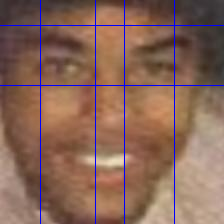

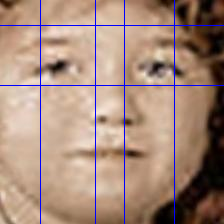

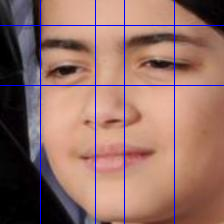

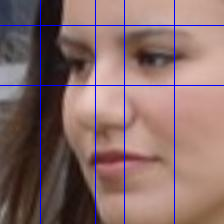

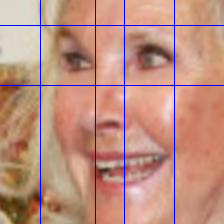

In [ ]:
for image in images:
  image_lines = image.copy()
  lines = [
    (  # above eye line
      (0, image_lines.shape[0] * 7 // 24 - 40),
      (image_lines.shape[1], image_lines.shape[0] * 7 // 24 - 40)
    ),
    (  # left eye left extremity
      (image_lines.shape[1] * 7 // 24 - 25, 0),
      (image_lines.shape[1] * 7 // 24 - 25, image_lines.shape[0])
    ),
    (  # left eye right extremity
      (image_lines.shape[1] * 7 // 24 + 30, 0),
      (image_lines.shape[1] * 7 // 24 + 30, image_lines.shape[0])
    ),
    (  # right eye left extremity
      (image_lines.shape[1] * 2 // 3 - 25, 0),
      (image_lines.shape[1] * 2 // 3 - 25, image_lines.shape[0])
    ),
    (  # right eye right extremity
      (image_lines.shape[1] * 2 // 3 + 25, 0),
      (image_lines.shape[1] * 2 // 3 + 25, image_lines.shape[0])
    ),
    (  # under eye line
      (0, image_lines.shape[0] * 7 // 24 + 20),
      (image_lines.shape[1], image_lines.shape[0] * 7 // 24 + 20)
    ),
  ]
  for line in lines:
      cv.line(
          image_lines,
          line[0],
          line[1],
          (255, 0, 0),
          1
      )
  show_image(image_lines)

Definiti le posizioni dei contorni, sono stati disegnati i due rettangoli come determinato.

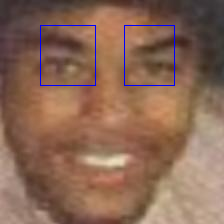

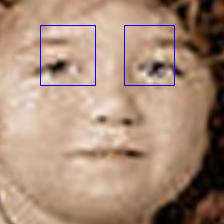

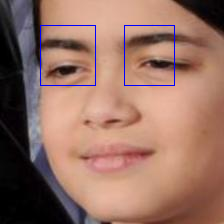

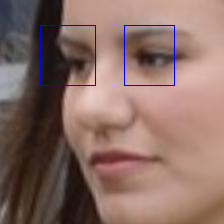

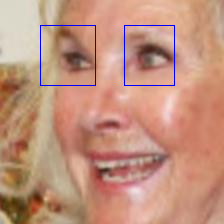

In [ ]:
for image in images:
  image_lines = image.copy()
  cv.rectangle(
    image_lines,
    (image_lines.shape[1] * 7 // 24 - 25, image_lines.shape[0] * 7 // 24 - 40),
    (image_lines.shape[1] * 7 // 24 + 30, image_lines.shape[0] * 7 // 24 + 20),
    (255, 0, 0),
    1
  )
  cv.rectangle(
    image_lines,
    (image_lines.shape[1] * 2 // 3 - 25, image_lines.shape[0] * 7 // 24 - 40),
    (image_lines.shape[1] * 2 // 3 + 25, image_lines.shape[0] * 7 // 24 + 20),
    (255, 0, 0),
    1
  )
  show_image(image_lines)

In seguito è stato applicato un filtro gaussiano su entrambe le sottoimmagini estratte di dimensioni 3x3 e sigma 0. Subito dopo, sono stati estratti i contorni di occhi e sopracciglia mediante "Canny edge detector" usando come soglie di isteresi 40 e 50 e un gradiente più accurato.

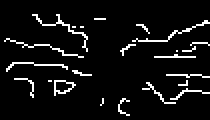

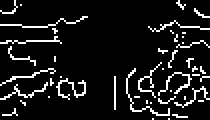

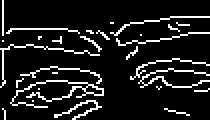

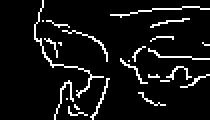

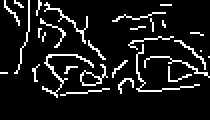

In [ ]:
cannys = []
for image in images:
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  left_eye_cropped = image_gray[
    (image_gray.shape[0] * 7 // 24 - 40):(image_gray.shape[0] * 7 // 24 + 20),
    (image_gray.shape[1] * 7 // 24 - 25):(image_gray.shape[1] * 7 // 24 + 30)
  ]
  right_eye_cropped = image_gray[
    (image_gray.shape[0] * 7 // 24 - 40):(image_gray.shape[0] * 7 // 24 + 20),
    (image_gray.shape[1] * 2 // 3 - 25):(image_gray.shape[1] * 2 // 3 + 25)
  ]
  left_eye_blurred = cv.GaussianBlur(left_eye_cropped, (3, 3), 0)
  right_eye_blurred = cv.GaussianBlur(right_eye_cropped, (3, 3), 0)
  left_eye_canny = cv.Canny(left_eye_blurred, 40, 50, L2gradient=True)
  right_eye_canny = cv.Canny(right_eye_blurred, 40, 50, L2gradient=True)
  cannys.append((left_eye_canny, right_eye_canny))
  show_image(cv.resize(np.hstack([left_eye_canny, right_eye_canny]), None, None, 2, 2, cv.INTER_NEAREST))
  print()

Sono poi stati chiusi eventuali contorni scollegati tra di loro con un'operazione di chiusura morfologica e poi sono state applicate due operazioni di dilatazione ed erosione per colmare ulteriori separazioni nell'immagine. Tutte le operazioni sono state fatte usando lo stesso elemento strutturante 5x5 ellissoidale su entrambe le sottoimmagini.

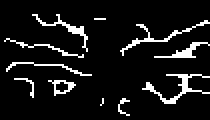

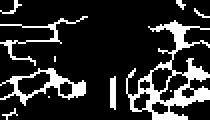

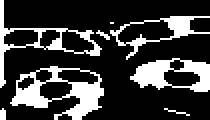

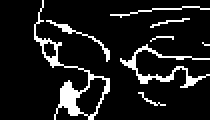

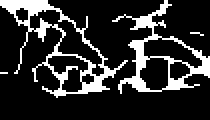

In [ ]:
morphed = []

for (left_image, right_image) in cannys:
  elem = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
  left_closed = cv.morphologyEx(left_image, cv.MORPH_CLOSE, elem)
  right_closed = cv.morphologyEx(right_image, cv.MORPH_CLOSE, elem)
  left_dilated = cv.morphologyEx(left_closed, cv.MORPH_DILATE, elem)
  right_dilated = cv.morphologyEx(right_closed, cv.MORPH_DILATE, elem)
  left_eroded = cv.morphologyEx(left_dilated, cv.MORPH_ERODE, elem)
  right_eroded = cv.morphologyEx(right_dilated, cv.MORPH_ERODE, elem)
  morphed.append((left_eroded, right_eroded))
  show_image(cv.resize(np.hstack([left_eroded, right_eroded]), None, None, 2, 2, cv.INTER_NEAREST))
  print()

Da ultimo, vengono estratti i descrittori di forma per gli occhi e le sopracciglia. In caso le operazioni precedenti siano state effettuate in modo tale da ottenere risultati sensati, la componente connessa di area più grande, quindi che contiene il maggior numero di pixel, è necessariamente l'occhio. Individuata la componente connessa, è facile trovare il centroide, l'elongazione e i suoi contorni. Dai contorni si ottiene il *convex hull* e così la convessità. Infine, vengono calcolati i descrittori ellittici di Fourier per il contorno dell'occhio come precedentemente estratto.

L'individuazione del sopracciglio è leggermente più complesso. Innanzitutto, si eliminano tutte le componenti connesse il cui centroide ha una ordinata pari o superiore all'ordinata più in alto della *bounding box* della componente connessa dell'occhio. Questo perché ci aspettiamo che il sopracciglio si trovi sempre e comunque al di sopra dell'occhio e mai sotto o all'interno di questo. Limitarsi a considerare il centroide della componente connessa e non le dimensioni della stessa permette sovrapposizioni tra le *bounding box* di queste, che è sempre possibile. Tra tutte le componenti connesse si sceglie sempre quella di area maggiore, che dovrebbe essere il risultato dell'aggregazione delle diverse parti del contorno del sopracciglio.

----------------------------------


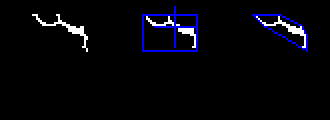

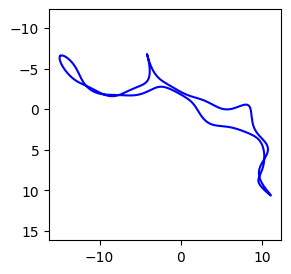


eye elongation:0.3214285714285714, eye convexity:0.7727932820168568


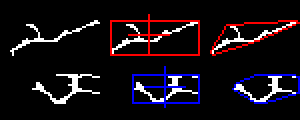

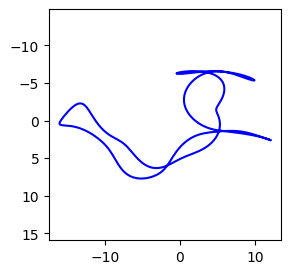

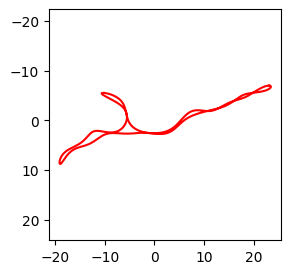


eye elongation:0.5588235294117647, eye convexity:0.5754128794175539
eyebrow elongation:0.6, eyebrow convexity:0.7827311879863641

----------------------------------


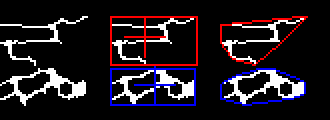

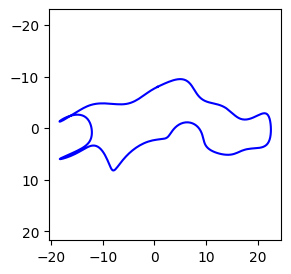

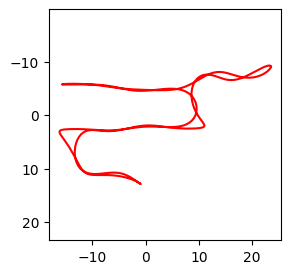


eye elongation:0.5581395348837209, eye convexity:0.7289697145860489
eyebrow elongation:0.43181818181818177, eyebrow convexity:0.520070828237021



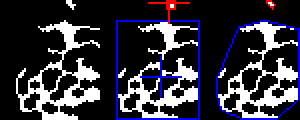

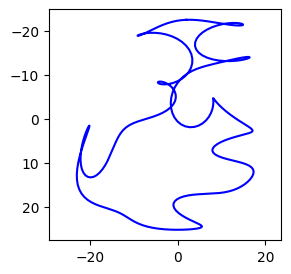

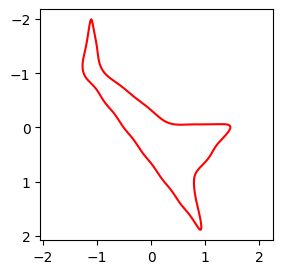


eye elongation:-0.19047619047619047, eye convexity:0.426971466275694
eyebrow elongation:0.0, eyebrow convexity:0.9415555014551922

----------------------------------


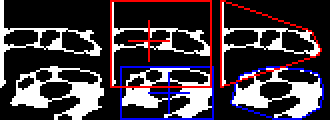

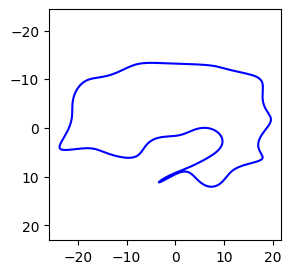

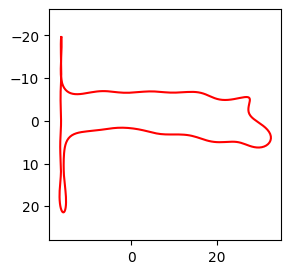


eye elongation:0.42553191489361697, eye convexity:0.7008866027132691
eyebrow elongation:0.13725490196078427, eyebrow convexity:0.8083787469860497



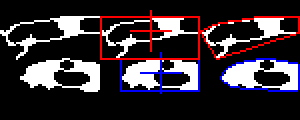

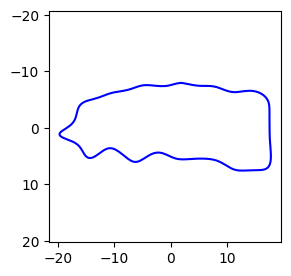

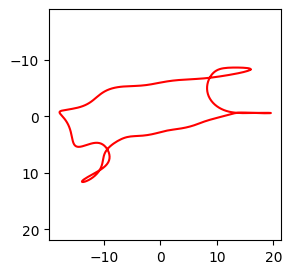


eye elongation:0.575, eye convexity:0.9263649618710106
eyebrow elongation:0.56, eyebrow convexity:0.7652467614366057

----------------------------------


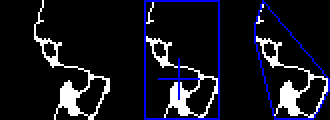

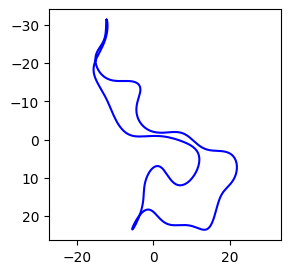


eye elongation:-0.5789473684210527, eye convexity:0.6476222821562753


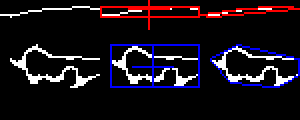

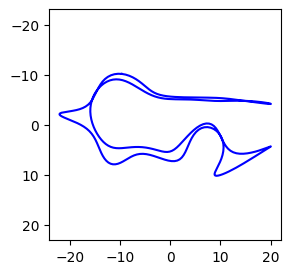

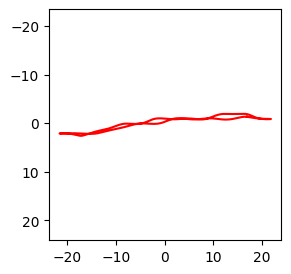


eye elongation:0.5111111111111111, eye convexity:0.46916909208576907
eyebrow elongation:0.88, eyebrow convexity:0.9578075420444827

----------------------------------


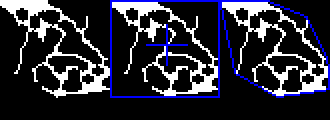

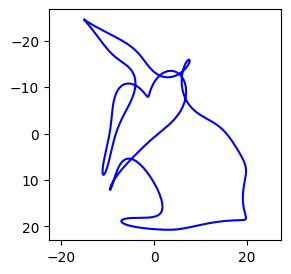


eye elongation:0.10909090909090913, eye convexity:0.5265780299650491


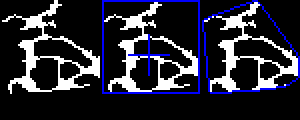

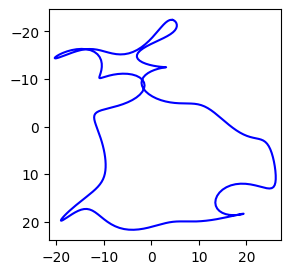


eye elongation:0.04081632653061229, eye convexity:0.5514236285827607


In [ ]:
for (left_image, right_image) in morphed:
  print("----------------------------------")

  for image in [left_image, right_image]:
    (num_labels, labels, stats, centroids) = cv.connectedComponentsWithStats(image)

    if num_labels < 3:
      print("No eye or eyebrow found")
      break

    biggest_cc = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1
    eye_centroid = centroids[biggest_cc]
    eye_elongation = 1 - stats[biggest_cc, cv.CC_STAT_HEIGHT] / stats[biggest_cc, cv.CC_STAT_WIDTH]

    eye_shape = np.array((labels == biggest_cc) * 255, dtype=np.uint8)
    eye_contours, _ = cv.findContours(eye_shape, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    eye_convex_hull = cv.convexHull(eye_contours[0])
    eye_convexity = cv.arcLength(eye_convex_hull, True) / cv.arcLength(eye_contours[0], True)

    eye_elliptic_coeffs = elliptic_fourier_descriptors(np.squeeze(eye_contours[0]), order=16)

    shape = eye_shape
    shape_with_bb = cv.rectangle(
      np.stack([eye_shape, eye_shape, eye_shape], axis=2),
      (stats[biggest_cc, cv.CC_STAT_LEFT], stats[biggest_cc, cv.CC_STAT_TOP]),
      (
        stats[biggest_cc, cv.CC_STAT_LEFT] + stats[biggest_cc, cv.CC_STAT_WIDTH] - 1,
        stats[biggest_cc, cv.CC_STAT_TOP] + stats[biggest_cc, cv.CC_STAT_HEIGHT] - 1
      ),
      (255, 0, 0),
      1
    )
    cv.drawMarker(
      shape_with_bb,
      (int(eye_centroid[0]), int(eye_centroid[1])),
      (255, 0, 0),
      cv.MARKER_CROSS
    )

    shape_with_ch = cv.drawContours(
      np.stack([eye_shape, eye_shape, eye_shape], axis=2),
      [eye_convex_hull],
      0,
      (255, 0, 0),
      1
    )

    possible_eyebrows = np.hstack([np.expand_dims(np.arange(1, num_labels), axis=1), centroids[1:]])
    possible_eyebrows = \
      possible_eyebrows[possible_eyebrows[:, 2] < stats[biggest_cc, cv.CC_STAT_TOP]][:, 0].astype(int)

    if possible_eyebrows.size != 0:
      second_biggest_cc = possible_eyebrows[np.argmax(stats[possible_eyebrows, cv.CC_STAT_AREA])]
      eyebrow_centroid = centroids[second_biggest_cc]
      eyebrow_elongation = 1 - stats[second_biggest_cc, cv.CC_STAT_HEIGHT] / stats[second_biggest_cc, cv.CC_STAT_WIDTH]

      eyebrow_shape = np.array((labels == second_biggest_cc) * 255, dtype=np.uint8)
      eyebrow_contours, _ = cv.findContours(eyebrow_shape, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
      eyebrow_convex_hull = cv.convexHull(eyebrow_contours[0])
      eyebrow_convexity = cv.arcLength(eyebrow_convex_hull, True) / cv.arcLength(eyebrow_contours[0], True)

      eyebrow_elliptic_coeffs = elliptic_fourier_descriptors(np.squeeze(eyebrow_contours[0]), order=16)

      shape = cv.bitwise_or(shape, eyebrow_shape)
      shape_with_bb = cv.rectangle(
        cv.bitwise_or(shape_with_bb, np.dstack([eyebrow_shape, eyebrow_shape, eyebrow_shape])),
        (stats[second_biggest_cc, cv.CC_STAT_LEFT], stats[second_biggest_cc, cv.CC_STAT_TOP]),
        (
          stats[second_biggest_cc, cv.CC_STAT_LEFT] + stats[second_biggest_cc, cv.CC_STAT_WIDTH] - 1,
          stats[second_biggest_cc, cv.CC_STAT_TOP] + stats[second_biggest_cc, cv.CC_STAT_HEIGHT] - 1
        ),
        (0, 0, 255),
        1
      )
      cv.drawMarker(
        shape_with_bb,
        (int(eyebrow_centroid[0]), int(eyebrow_centroid[1])),
        (0, 0, 255),
        cv.MARKER_CROSS
      )

      shape_with_ch = cv.drawContours(
        cv.bitwise_or(shape_with_ch, np.dstack([eyebrow_shape, eyebrow_shape, eyebrow_shape])),
        [eyebrow_convex_hull],
        0,
        (0, 0, 255),
        1
      )

    show_image(cv.resize(
      np.hstack([np.dstack([shape, shape, shape]), shape_with_bb, shape_with_ch]),
        None,
        None,
        2,
        2,
        cv.INTER_NEAREST
    ))
    print()
    t = np.linspace(0, 1.0, 300)
    xt = np.zeros((300,))
    yt = np.zeros((300,))
    for n in range(eye_elliptic_coeffs.shape[0]):
      xt += (eye_elliptic_coeffs[n, 0] * np.cos(2 * (n + 1) * np.pi * t)) + (
        eye_elliptic_coeffs[n, 1] * np.sin(2 * (n + 1) * np.pi * t)
      )
      yt += (eye_elliptic_coeffs[n, 2] * np.cos(2 * (n + 1) * np.pi * t)) + (
        eye_elliptic_coeffs[n, 3] * np.sin(2 * (n + 1) * np.pi * t)
      )
    plt.figure(figsize=(3, 3))
    plt.plot(xt, yt, "b")
    plt.gca().invert_yaxis()
    plt.axis("equal")
    plt.show()
    if possible_eyebrows.size != 0:
      xt = np.zeros((300,))
      yt = np.zeros((300,))
      for n in range(eyebrow_elliptic_coeffs.shape[0]):
        xt += (eyebrow_elliptic_coeffs[n, 0] * np.cos(2 * (n + 1) * np.pi * t)) + (
          eyebrow_elliptic_coeffs[n, 1] * np.sin(2 * (n + 1) * np.pi * t)
        )
        yt += (eyebrow_elliptic_coeffs[n, 2] * np.cos(2 * (n + 1) * np.pi * t)) + (
          eyebrow_elliptic_coeffs[n, 3] * np.sin(2 * (n + 1) * np.pi * t)
        )
      plt.figure(figsize=(3, 3))
      plt.plot(xt, yt, "r")
      plt.gca().invert_yaxis()
      plt.axis("equal")
      plt.show()
    print(f"\neye elongation:{eye_elongation}, eye convexity:{eye_convexity}")
    if possible_eyebrows.size != 0:
      print(f"eyebrow elongation:{eyebrow_elongation}, eyebrow convexity:{eyebrow_convexity}\n")

In questo modo, è stato possibile determinare il processo di estrazione della forma degli occhi e delle sopracciglia. Nel caso in cui non venga trovata neanche una componente connessa, cioè l'immagine trasformata non contenga nessun potenziale contorno degli occhi, semplicemente viene restituito un valore speciale. Se viene trovata solamente la componente connessa degli occhi e non quella delle sopracciglia, viene restituito un valore speciale. Poiché in alcune immagini la componente connessa delle sopracciglia è fatta da un solo pixel, la lunghezza del perimetro non può essere calcolata, così come i descrittori di Fourier ellittici. Anche in questo caso viene restituito un valore speciale, in modo tale che, come nei casi precedenti, l'immagine possa essere eliminata dall'estrazione delle feature.
Le posizioni dei centroidi sono normalizzate dividendole per le dimensioni dell'immagine.

In [ ]:
def extract_eye_eyebrow_shape(image):
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  left_eye_cropped = image_gray[
    (image_gray.shape[0] * 7 // 24 - 40):(image_gray.shape[0] * 7 // 24 + 20),
    (image_gray.shape[1] * 7 // 24 - 25):(image_gray.shape[1] * 7 // 24 + 30)
  ]
  right_eye_cropped = image_gray[
    (image_gray.shape[0] * 7 // 24 - 40):(image_gray.shape[0] * 7 // 24 + 20),
    (image_gray.shape[1] * 2 // 3 - 25):(image_gray.shape[1] * 2 // 3 + 25)
  ]
  left_eye_blurred = cv.GaussianBlur(left_eye_cropped, (3, 3), 0)
  right_eye_blurred = cv.GaussianBlur(right_eye_cropped, (3, 3), 0)
  left_eye_canny = cv.Canny(left_eye_blurred, 40, 50, L2gradient=True)
  right_eye_canny = cv.Canny(right_eye_blurred, 40, 50, L2gradient=True)

  elem = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
  left_closed = cv.morphologyEx(left_eye_canny, cv.MORPH_CLOSE, elem)
  right_closed = cv.morphologyEx(right_eye_canny, cv.MORPH_CLOSE, elem)
  left_dilated = cv.morphologyEx(left_closed, cv.MORPH_DILATE, elem)
  right_dilated = cv.morphologyEx(right_closed, cv.MORPH_DILATE, elem)
  left_eroded = cv.morphologyEx(left_dilated, cv.MORPH_ERODE, elem)
  right_eroded = cv.morphologyEx(right_dilated, cv.MORPH_ERODE, elem)

  features = []

  for image in [left_eroded, right_eroded]:
    (num_labels, labels, stats, centroids) = cv.connectedComponentsWithStats(image)

    if num_labels < 3:
      return None

    biggest_cc = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1
    eye_centroid = centroids[biggest_cc]
    eye_elongation = 1 - stats[biggest_cc, cv.CC_STAT_HEIGHT] / stats[biggest_cc, cv.CC_STAT_WIDTH]

    eye_shape = np.array((labels == biggest_cc) * 255, dtype=np.uint8)
    eye_contours, _ = cv.findContours(eye_shape, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    eye_convex_hull = cv.convexHull(eye_contours[0])
    eye_convexity = cv.arcLength(eye_convex_hull, True) / cv.arcLength(eye_contours[0], True)
    features.append(np.array([
      eye_centroid[0] / image.shape[1],
      eye_centroid[1] / image.shape[0],
      eye_elongation,
      eye_convexity
    ]))

    eye_elliptic_coeffs = elliptic_fourier_descriptors(np.squeeze(eye_contours[0]), order=16, normalize=True).flatten()[3:]
    features.append(eye_elliptic_coeffs)

    possible_eyebrows = np.hstack([np.expand_dims(np.arange(1, num_labels), axis=1), centroids[1:]])
    possible_eyebrows = \
      possible_eyebrows[possible_eyebrows[:, 2] < stats[biggest_cc, cv.CC_STAT_TOP]][:, 0].astype(int)

    if possible_eyebrows.size != 0:
      second_biggest_cc = possible_eyebrows[np.argmax(stats[possible_eyebrows, cv.CC_STAT_AREA])]
      eyebrow_centroid = centroids[second_biggest_cc]
      eyebrow_elongation = 1 - stats[second_biggest_cc, cv.CC_STAT_HEIGHT] / stats[second_biggest_cc, cv.CC_STAT_WIDTH]

      eyebrow_shape = np.array((labels == second_biggest_cc) * 255, dtype=np.uint8)
      eyebrow_contours, _ = cv.findContours(eyebrow_shape, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
      eyebrow_convex_hull = cv.convexHull(eyebrow_contours[0])

      if cv.arcLength(eyebrow_contours[0], True) != 0:
        eyebrow_convexity = cv.arcLength(eyebrow_convex_hull, True) / cv.arcLength(eyebrow_contours[0], True)
        eyebrow_elliptic_coeffs = \
          elliptic_fourier_descriptors(np.squeeze(eyebrow_contours[0]), order=16, normalize=True).flatten()[3:]
      else:
        return None
    else:
      return None

    features.append(np.array([
        eyebrow_centroid[0] / image.shape[1],
        eyebrow_centroid[1] / image.shape[0],
        eyebrow_elongation,
        eyebrow_convexity
    ]))
    features.append(eyebrow_elliptic_coeffs)

  return np.concatenate(features)

### Tono della pelle

Per identificare il tono del colore della pelle, vengono prima segmentati i pixel che appartengono alla pelle del viso. Per farlo, viene utilizzata una tecnica basata su regole applicate agli spazi colore HSV e YCbCr. Il metodo utilizzato è quello documentato nell'articolo "[Zero-sum game theory model for segmenting skin regions](https://doi.org/10.1016/j.imavis.2020.103925)" di Dahmani, Cheref e Larabi. È uno tra i metodi che viene confrontato con quello proposto dagli autori nell'articolo e su alcuni dataset fornisce risultati anche migliori di quest'ultimo. Essendo un metodo molto rapido e dalle prestazioni ottime, è stato perciò scelto come candidato.

Il metodo si basa semplicemente sul convertire l'immagine sia nello spazio colore HSV che in quello YCbCr e poi sul trattenere tutti e soli i pixel con valore compreso in specifici intervalli. Dopodiché, le due immagini vengono messe in "and" bit a bit per ottenere il risultato finale. I valori per i diversi intervalli sono:

* 0 <= H <= 17
* 15 <= S <= 170
* 135 <= Cb <= 180
* 85 <= Cr <= 135

Poiché il metodo non dà risultati perfetti, nell'implementazione fornita da Cheref vengono effettuate delle operazioni di morfologia matematica sulle maschere ottenute, in particolare di apertura con elemento strutturante rettangolare 3x3. Sulla maschera finale, viene applicato prima un filtro di "median blur" 3x3 e poi un'ulteriore operazione di apertura con elemento strutturante rettangolare 4x4.

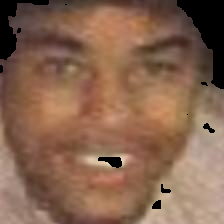

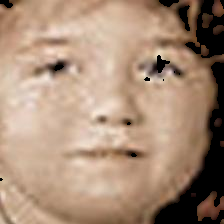

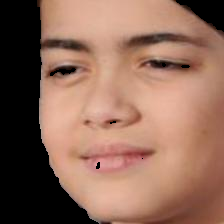

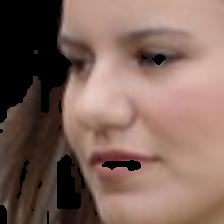

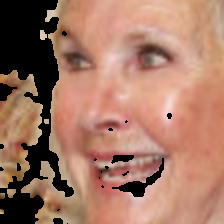

In [ ]:
segmented_faces = []

for image in images:
  elem = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
  hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
  hsv_mask = cv.inRange(hsv_image, (0, 15, 0), (17, 170, 255))
  hsv_mask = cv.morphologyEx(hsv_mask, cv.MORPH_OPEN, elem)
  ycbcr_image = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
  ycbcr_mask = cv.inRange(ycbcr_image, (0, 135, 85), (255, 180, 135))
  ycbcr_mask = cv.morphologyEx(ycbcr_mask, cv.MORPH_OPEN, elem)
  mask = cv.bitwise_and(ycbcr_mask, hsv_mask)
  mask = cv.medianBlur(mask, 3)
  elem_2 = cv.getStructuringElement(cv.MORPH_RECT, (4, 4))
  mask = cv.morphologyEx(mask, cv.MORPH_OPEN, elem_2)
  segmented_faces.append(image[mask != 0])
  show_image(cv.bitwise_and(image, np.dstack([mask, mask, mask])))

Una volta segmentati i pixel del volto, è stato determinato il colore della pelle. L'idea è stata quella per la quale i diversi colori possano essere messi su di una scala dove il parametro che varia è la luminosità degli stessi, mentre il contenuto cromatico rimane essenzialmente invariato. Di fatto, il colore della pelle è dato dalla maggiore o minore presenza di un pigmento all'interno della stessa, che determina il suo essere più scura o più chiara, senza modificare le altre proprietà del colore, perciò variando luminosità mantenendo tinta e saturazione invariate. Questa ipotesi è supportata dal fatto che il metodo precedente di segmentazione del volto impone vincoli sulle componenti di "hue" e "saturation" nello spazio HSV e sulle componenti "Cb" e "Cr" nello spazio "YCbCr", ma lascia libero di variare "value" e "Y", che rappresentano con a caso la luminosità dell'immagine.

Per implementare questa idea, sono stati utilizzati dei campioni di colore pensati appositamente per rappresentare i diversi toni del viso. Questi campioni provengono dalla palette di colori "[Monk skin tone scale](https://blog.google/products/search/monk-skin-tone-scale/)" sviluppata da Google per migliorare la rappresentazione delle diverse etnie nei suoi prodotti, pertanto ci si aspetta che sia capace di coprire con sufficiente accuratezza l'intero spettro dei colori facciali. I colori sono stati direttamente rappresentati nello spazio colore CIE La\*b\* per facilitare le operazioni successive.

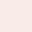

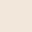

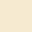

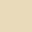

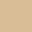

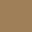

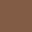

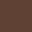

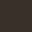

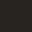

In [ ]:
skin_tones = [
  (94.211, 1.503, 5.422),
  (92.275, 2.061, 7.28),
  (93.091, 0.216, 14.205),
  (87.573, 0.459, 17.748),
  (77.902, 3.471, 23.136),
  (55.142, 7.783, 26.74),
  (42.47, 12.325, 20.53),
  (30.678, 11.667, 13.335),
  (21.069, 2.69, 5.964),
  (14.61, 1.482, 3.525)
]
color_images = []
for skin_tone in skin_tones:
  color_image = np.full((32, 32, 3), list(skin_tone), dtype=np.float32)
  color_image = (cv.cvtColor(color_image, cv.COLOR_Lab2BGR) * 255).astype(np.uint8)
  color_images.append(color_image)
  show_image(color_image)
  print()

Fissata la palette di riferimento, non è stato fatto altro che utilizzare i pixel del volto estratti al passo precedente per convertirli in virgola mobile, così da poter applicare la trasformazione nello spazio colore La\*b\*. Per ogni tonalità nella palette, si è costruito un *array* con stessa dimensione del numero di pixel estratti di ciascun volto, in modo tale da poter applicare la formula cosiddetta $\Delta E^\ast$ per la differenza tra colori.

Questa formula si applica infatti nello spazio La\*b\* perché è pensato per meglio rappresentare la vicinanza dei colori da un punto di vista percettivo umano e perciò alcune metriche come appunto la distanza hanno maggiore significato. Inoltre, la formula è stata pensata e studiata per evidenziare le differenze anche impercettibili tra diverse tinte di uno stesso prodotto a livello industriale, perciò vuole essere particolarmente robusta. La variante impiegata è la CIE 2000, ovvero la più raffinata della famiglia di formule $\Delta E^\ast$.

Una volta determinata la distanza tra il colore di ciascun pixel e il colore della palette attualmente in esame, si prende la media tra queste. Minimi e massimi non sono affidabili, perché potrebbero essere influenzati da pixel spuri, come anche macchie della pelle o riflessi. Il valore medio aiuta a ridurre il peso di questi *outlier*, rimanendo comunque spostato verso il valore della maggioranza dei pixel. Il descrittore è poi costruito dalla concatenazione delle diverse medie.

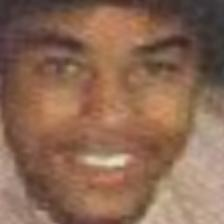

[38.257385, 36.863598, 37.6739, 34.655308, 28.297333, 13.870974, 11.453651, 17.820473, 25.957386, 30.456787]


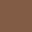

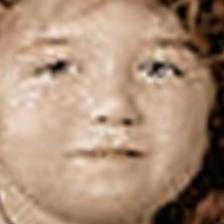

[23.31005, 21.675644, 22.496014, 19.689175, 14.437975, 15.246352, 23.804853, 35.148552, 43.902557, 48.444035]


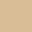

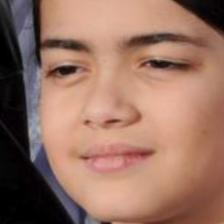

[28.5189, 27.005373, 28.340542, 25.601112, 19.537313, 15.228737, 20.406605, 30.90839, 40.206985, 44.439827]


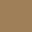

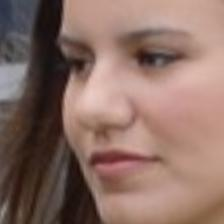

[36.139156, 34.8614, 36.705204, 34.16783, 28.063175, 18.742294, 19.737053, 25.458471, 31.458565, 35.231815]


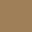

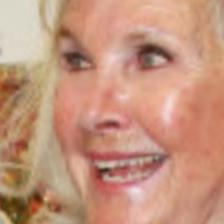

[26.438242, 24.936596, 26.31676, 23.665718, 17.86531, 14.982573, 22.155064, 33.532856, 42.772087, 47.067722]


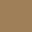

In [ ]:
for (original, image) in zip(images, segmented_faces):
  means = []
  image_lab = cv.cvtColor(np.expand_dims(image, axis=0).astype(np.float32) / 255, cv.COLOR_BGR2Lab)
  for skin_tone in skin_tones:
    color_lab = np.full_like(image_lab, list(skin_tone), dtype=np.float32)
    mean_diff = deltaE_ciede2000(image_lab, color_lab).mean()
    means.append(mean_diff)
  show_image(original)
  print(means)
  show_image(color_images[np.argmin(means)])

Detto questo, è stato possibile costruire il metodo di estrazione della tonalità del viso. Poiché talvolta non viene individuato nemmeno un pixel come appartenente al viso, in questi casi estremi vengono utilizzati tutti i pixel dell'immagine, che sono sempre e comunque in maggioranza i pixel del volto.

In [ ]:
def extract_skin_tone(image):
  skin_tones = [
    (94.211, 1.503, 5.422),
    (92.275, 2.061, 7.28),
    (93.091, 0.216, 14.205),
    (87.573, 0.459, 17.748),
    (77.902, 3.471, 23.136),
    (55.142, 7.783, 26.74),
    (42.47, 12.325, 20.53),
    (30.678, 11.667, 13.335),
    (21.069, 2.69, 5.964),
    (14.61, 1.482, 3.525)
  ]
  elem = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
  hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
  hsv_mask = cv.inRange(hsv_image, (0, 15, 0), (17, 170, 255))
  hsv_mask = cv.morphologyEx(hsv_mask, cv.MORPH_OPEN, elem)
  ycbcr_image = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
  ycbcr_mask = cv.inRange(ycbcr_image, (0, 135, 85), (255, 180, 135))
  ycbcr_mask = cv.morphologyEx(ycbcr_mask, cv.MORPH_OPEN, elem)
  mask = cv.bitwise_and(ycbcr_mask, hsv_mask)
  mask = cv.medianBlur(mask, 3)
  elem_2 = cv.getStructuringElement(cv.MORPH_RECT, (4, 4))
  mask = cv.morphologyEx(mask, cv.MORPH_OPEN, elem_2)
  pixels = image[mask != 0]
  if pixels.shape[0] == 0:
    pixels = image.reshape((image.shape[0] * image.shape[1], 3))
  means = []
  image_lab = cv.cvtColor(np.expand_dims(pixels, axis=0).astype(np.float32) / 255, cv.COLOR_BGR2Lab)
  for skin_tone in skin_tones:
    color_lab = np.full_like(image_lab, list(skin_tone), dtype=np.float32)
    mean_diff = deltaE_ciede2000(image_lab, color_lab).mean()
    means.append(mean_diff)
  return np.array(means)

### Colore degli occhi

Per quanto riguarda il colore degli occhi, di norma ha una tonalità ben diversa da quelli circostanti, rendendolo un descrittore relativamente facile da estrarre. In questo caso però non possiamo assumere che il loro colore sia dato dalla maggiore o minore presenza di un pigmento al loro interno perché, oltre a non essere vero, quelle che sono considerate le principali varianti, ovvero "marroni", "verdi" e "azzurri", hanno tonalità molto diverse tra di loro. Inoltre, il colore di un occhio ha molte sfumature date dalla sua conformazione interna, anche se in questo caso non possono certo essere apprezzabili.

Per prima cosa, è stato necessario andare ad inviduare la posizione degli occhi, che in tutte le immagini si trova sempre all'incirca nella stessa posizione. Questi si trovano all'incirca ad un'altezza che è i 7/24 dell'immagine. L'occhio sinistro si trova ai 7/24 della larghezza dell'immagine, mentre quello destro ai 2/3.

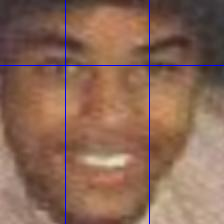

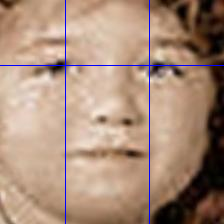

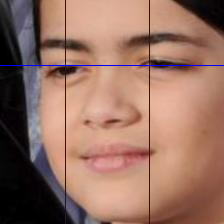

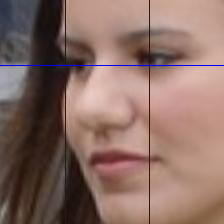

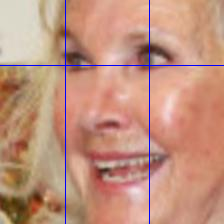

In [ ]:
for image in images:
  image_lines = image.copy()
  lines = [
      (  # eye line
          (0, image_lines.shape[0] * 7 // 24),
          (image_lines.shape[1], image_lines.shape[0] * 7 // 24)
      ),
      (  # left eye
          (image_lines.shape[1] * 7 // 24, 0),
          (image_lines.shape[1] * 7 // 24, image_lines.shape[0])
      ),
      (  # right eye
          (image_lines.shape[1] * 2 // 3, 0),
          (image_lines.shape[1] * 2 // 3, image_lines.shape[0])
      ),
  ]
  for line in lines:
      cv.line(
          image_lines,
          line[0],
          line[1],
          (255, 0, 0),
          1
      )
  show_image(image_lines)

Dopodiché, si è andati a determinare un ellisse attorno al presunto centro dell'occhio, fatto in modo tale da far ricadere al suo interno tutti i pixel dell'occhio. Questa ellisse ha un rapporto tra gli assi di 2:1, in quanto l'occhio umano è più largo che lungo.

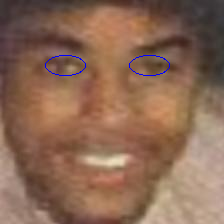

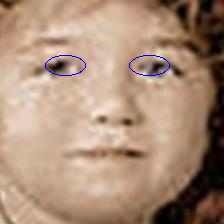

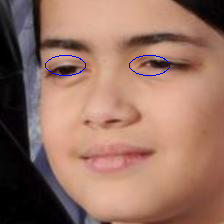

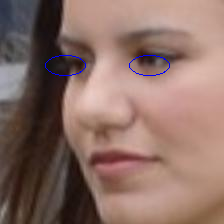

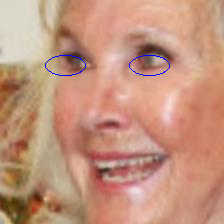

In [ ]:
for image in images:
  image_ellipse = image.copy()
  cv.ellipse(
      image_ellipse,
      (image_lines.shape[1] * 7 // 24, image_lines.shape[0] * 7 // 24),
      (20, 10),
      0,
      0,
      360,
      (255, 0, 0),
      1
  )
  cv.ellipse(
      image_ellipse,
      (image_lines.shape[1] * 2 // 3, image_lines.shape[0] * 7 // 24),
      (20, 10),
      0,
      0,
      360,
      (255, 0, 0),
      1
  )
  show_image(image_ellipse)

Questo ellisse è stato poi utilizzato per determinare una maschera da applicare sull'immagine in *grayscale* per estrapolare i pixel degli occhi. Sull'immagine con applicata la maschera sono stati poi posti tutti i pixel esterni ad essa ad una luminosità pari a 255 e poi è stato applicato thresholding globale binario inverso, che perciò pone a 255 tutti i pixel al di sotto di una certa soglia. La soglia, scelta manualmente, è pari a 120. Questo ha prodotto una maschera pensata per estrarre solamente i pixel dell'iride ed eliminare tutti quelli associati alla sclera, ovvero la parte bianca dell'occhio, più chiara.

Riutilizzare la tecnica precedente, ovvero quella di segmentazione dei pixel del viso non avrebbe dato risultati soddisfacenti. Purtroppo i pixel che compongono l'occhio sono molto pochi ed eliminarne qualcuno di troppo avrebbe potuto compromettere effettivamente il funzionamento del descrittore. Dato che la tecnica di segmentazione trattiene molto spesso pixel che non fanno parte del viso vero e proprio, quindi anche degli occhi, creare una maschera "al contrario" avrebbe significato quasi sicuramente perdere pixel che invece dell'occhio fanno parte. Visto che comunque utilizzando la tecnica descritta si restringe molto il campo dei potenziali pixel dell'occhio, ci si è limitati al tentativo di eliminare la sclera.

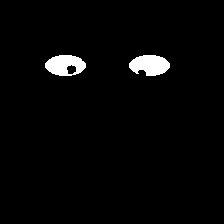

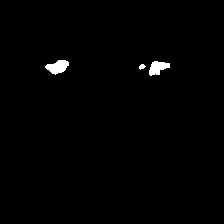

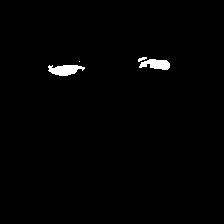

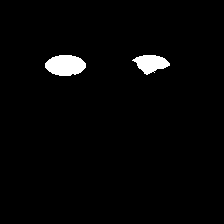

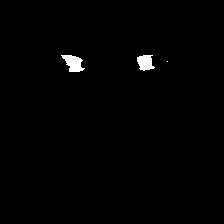

In [ ]:
thresholds = []

for image in images:
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  eye_mask = np.zeros((image_gray.shape[0], image_gray.shape[1]), dtype=np.uint8)
  cv.ellipse(
    eye_mask,
    (eye_mask.shape[1] * 7 // 24, eye_mask.shape[0] * 7 // 24),
    (20, 10),
    0,
    0,
    360,
    255,
    -1
  )
  cv.ellipse(
    eye_mask,
    (image_lines.shape[1] * 2 // 3, image_lines.shape[0] * 7 // 24),
    (20, 10),
    0,
    0,
    360,
    255,
    -1
  )
  image_masked = cv.bitwise_and(image_gray, eye_mask)
  image_masked = image_masked + cv.bitwise_not(eye_mask)
  _, threshold = cv.threshold(image_masked, 120, 255, cv.THRESH_BINARY_INV)
  thresholds.append(threshold)
  show_image(threshold)

La maschera è stata poi applicata all'immagine per estrarre il *color histogram* dell'iride, che è stato calcolato come l'istogramma sul canale "hue" dell'immagine nello spazio colore "HSV".

Un istogramma calcolato solamente sul canale "hue" è sufficiente perché, in primo luogo, questo ci rende indipendenti dalla luminosità dell'immagine, che certamente influenza il colore dell'occhio. In secondo luogo, a noi interessa prevalentemente sapere la tonalità, quindi se l'occhio è più marrone, più verde o più azzurro. Per ottenere queste informazioni basta osservare come sono collocati i valori nell'istogramma: se sono presenti solamente tra il rosa e l'arancione, allora l'occhio è prevalentemente marrone, se sono presenti valori tra i verdi allora l'occhio è più verde, mentre se sono presenti valori tra i blu, allora l'occhio è azzurro. Poiché a causa del colore della pelle circostante i toni del rosso e dell'arancione rimangono sempre molto alti a prescindere dal colore dell'occhio, avrebbero potuto essere eliminati dall'istogramma. Si è però preferito lasciarli e fare in modo che sia il successivo classificatore a determinare la loro utilità o meno.

L'istogramma colore così calcolato è stato poi normalizzato: ci interessa il rapporto relativo tra le diverse tonalità e non il valore assoluto delle stesse, che dipende dal numero di pixel sui quali è stato calcolato l'istogramma e il cui valore può portare fuori strada un potenziale classificatore a causa del loro ordine di grandezza.

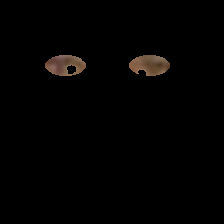

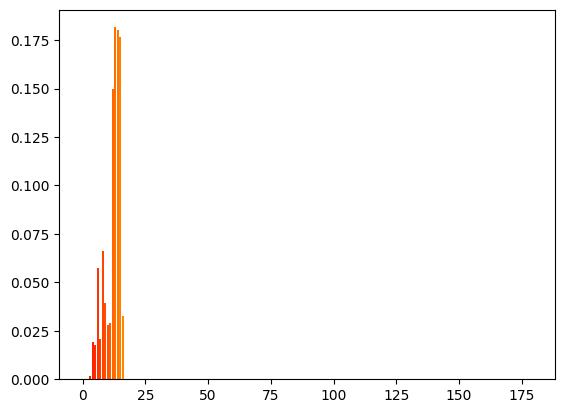

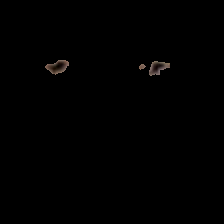

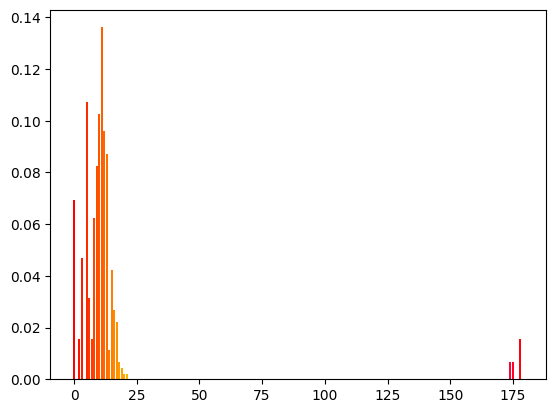

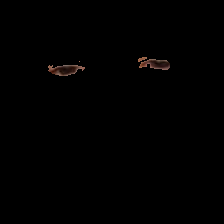

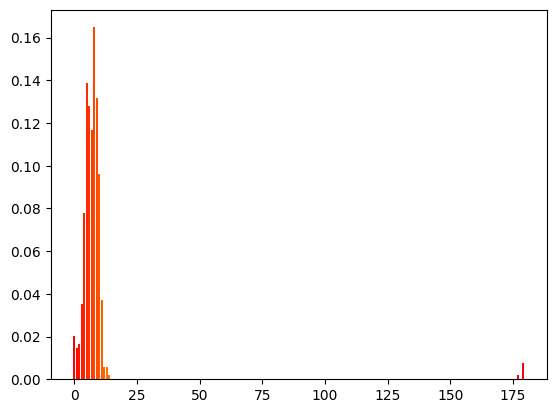

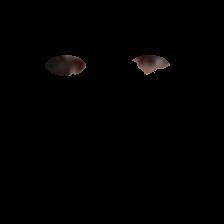

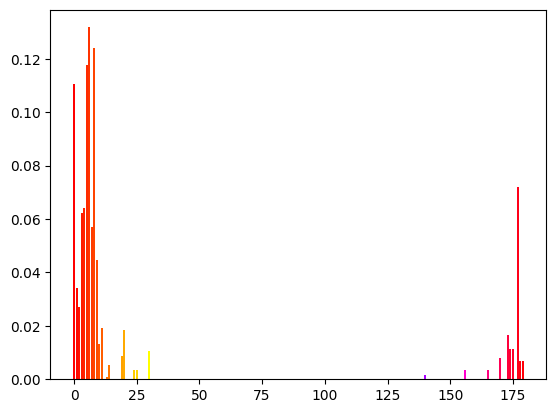

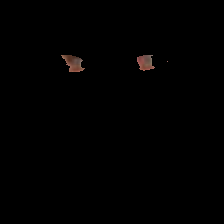

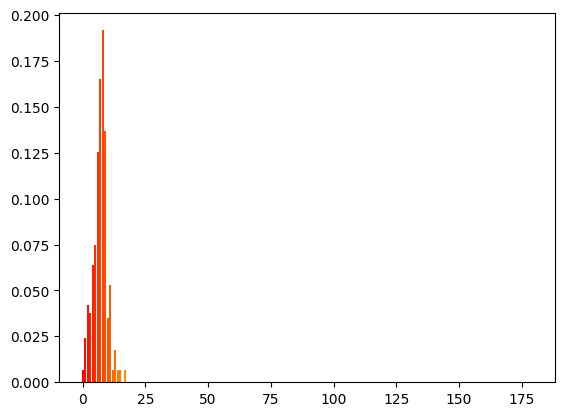

In [ ]:
for (image, mask) in zip(images, thresholds):
  image_hue = cv.split(cv.cvtColor(image, cv.COLOR_BGR2HSV))[0]
  hue_hist = np.squeeze(cv.calcHist([image_hue], [0], mask, [180], [0, 180]), axis=1)
  norm_hue_hist = hue_hist / np.sum(hue_hist)
  show_image(cv.bitwise_and(image, np.stack([mask, mask, mask], axis=2)))
  barchart = plt.bar(
    list(range(0, 180)),
    norm_hue_hist,
    color=(np.squeeze(cv.cvtColor(
      np.array([[[x, 255, 255]] for x in range(0, 180)], dtype=np.uint8),
      cv.COLOR_HSV2RGB
    ), axis=1) / 255).tolist()
  )
  plt.show()

In questo modo, si è determinato il processo di estrazione del colore degli occhi da un'immagine, esemplificato dalla funzione seguente. Nel caso in cui non sia stato individuato neanche un pixel come appartenente agli occhi e perciò la somma dei valori nell'istogramma sia zero, viene restituito un valore speciale. Questo servirà per eliminare l'immagine successivamente.

In [ ]:
def extract_eyes_hue(image):
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  eye_mask = np.zeros((image_gray.shape[0], image_gray.shape[1]), dtype=np.uint8)
  cv.ellipse(
    eye_mask,
    (eye_mask.shape[1] * 7 // 24, eye_mask.shape[0] * 7 // 24),
    (20, 10),
    0,
    0,
    360,
    255,
    -1
  )
  cv.ellipse(
    eye_mask,
    (image_lines.shape[1] * 2 // 3, image_lines.shape[0] * 7 // 24),
    (20, 10),
    0,
    0,
    360,
    255,
    -1
  )
  image_masked = cv.bitwise_and(image_gray, eye_mask)
  image_masked = image_masked + cv.bitwise_not(eye_mask)
  _, threshold = cv.threshold(image_masked, 120, 255, cv.THRESH_BINARY_INV)
  image_hue = cv.split(cv.cvtColor(image, cv.COLOR_BGR2HSV))[0]
  hue_hist = np.squeeze(cv.calcHist([image_hue], [0], threshold, [180], [0, 180]), axis=1)
  if np.sum(hue_hist) == 0:
    return None
  else:
    return hue_hist / np.sum(hue_hist)

### Texture del volto

Come ultimo gruppo di feature, sono state estratte quelle inerenti alla texture del volto. Queste informazioni potrebbero essere utili per catturare informazioni ancora non individuate come lentiggini, nei, rughe o altre imperfezioni del viso che possono essere trasmesse geneticamente tra parenti.

I due metodi che permettono un'estrazione "handcrafted" delle feature che risultano allo stesso tempo più veloci e capaci di codificare meglio le informazioni sono i filtri di Gabor e i "Local Binary Pattern". Tra queste due tecniche si è preferito utilizzare la seconda, nella sua variante multiscala come illustrata nel *paper* "[Multiresolution gray-scale and rotation invariant texture classification with local binary patterns](https://doi.org/10.1109/TPAMI.2002.1017623)" di Ojala, Pietikainen e Maenpaa. La sua potenza risiede nel fatto che, se si considerano solamente i pattern cosiddetti "uniformi e invarianti per rotazione", i quali di norma compongono fino al 90% dei pattern in un'immagine, ne esistono solamente un numero fortemente limitato. Se si indica con $P$ il numero di pixel nell'intorno considerato, allora i pattern uniformi invarianti per rotazione sono solamente $P+2$, anziché i $2^p$ totali. Questo torna utile nella tecnica che li utilizza, che consiste nel suddividere l'immagine in sottoimmagini e per ciascuna estrarre l'istogramma dei L.P.B., che conterà solamente $P+3$ *bin*, uno in più per quelli non uniformi. Quando il descrittore sarà costruito, concatenando i diversi istogrammi, la rappresentazione sarà estremamente compatta ma contenente ancora molte informazioni sulla *texture* del volto.

Per mediare tra il numero delle feature estratte e le informazioni trattenute, si è deciso di suddividere l'immagine in 16 immagini 56x56, sufficientemente piccole. Su ognuna di esse vengono calcolati gli istogrammi di L.B.P. con raggio 1, e intorno dei pixel 8, e con raggio 2, e intorno dei pixel 16, come fossero due cornici rispettivamente 3x3 e 5x5. Ciascun istogramma è stato poi normalizzato.

I filtri di Gabor non sono stati considerati adeguati perché, per ottenere dei risultati simili, avrebbero dovuto quantomeno essere generati in un banco da 2 risoluzioni per 8 direzioni, quelle tipiche della distanza Chebyshev, per un totale di 16 filtri, senza contare gli altri parametri che si possono introdurre per modificare i filtri. Dopodiché, ciascuno di essi avrebbe dovuto essere applicato su di una "saliency image" che, anche nel caso possedesse un numero basso come un centinaio di posizioni, avrebbe voluto dire 1600 *feature*, contro le 448 che estraggono così i Local Binary Pattern.

In [ ]:
for image in images:
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  patterns = np.empty((0,), dtype=np.uint16)
  for neighboorhood in [(8, 1), (16, 2)]:
    for i in range(0, 4):
      for j in range(0, 4):
        pattern = local_binary_pattern(
          image_gray[(i * 56):((i + 1) * 56),(j * 56): ((j + 1) * 56)],
          neighboorhood[0],
          neighboorhood[1],
          "uniform"
        )
        hist, _ = np.histogram(pattern, neighboorhood[0] + 2, range=[0, neighboorhood[0] + 3])
        patterns = np.concatenate([patterns, hist / np.sum(hist)])
  print(patterns.shape)

(448,)
(448,)
(448,)
(448,)
(448,)


L'estrazione delle feature facciali è perciò facilmente codificata come segue.

In [ ]:
def extract_face_texture(image):
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  patterns = np.empty((0,), dtype=np.uint16)
  for neighboorhood in [(8, 1), (16, 2)]:
    for i in range(0, 4):
      for j in range(0, 4):
        pattern = local_binary_pattern(
          image_gray[(i * 56):((i + 1) * 56),(j * 56): ((j + 1) * 56)],
          neighboorhood[0],
          neighboorhood[1],
          "uniform"
        )
        hist, _ = np.histogram(pattern, neighboorhood[0] + 2, range=[0, neighboorhood[0] + 3])
        patterns = np.concatenate([patterns, hist / np.sum(hist)])
  return patterns

## Classificazione tradizionale

### Preparazione del dataset

Una volta determinate le *feature* da estrarre, non si è fatto altro che effettuare la loro elaborazione per ogni immagine a colori corretta, indipendentemente dal fatto che quest'ultima appartenesse al *training set* o al *test set*. Come già osservato in precedenza, nel caso in cui da un'immagine non fosse possibile estrarre una o più *feature*, questa viene interamente scartata. Per questo motivo, è necessario salvare assieme ai *feature vector* i percorsi che fanno riferimento all'immagine da cui sono stati estratti.

Le operazioni di estrazione necessitano di un po' di tempo per essere portate a termine, a causa dei descrittori di Fourier ellittici, dei Local Binary Pattern e del calcolo della funzione $\Delta E^\ast$, ognuno dei quali richiede un tempo non irrilevante per essere calcolato. Alla fine delle diverse trasformazioni, perciò, le *feature* saranno salvate in file pensati per realizzare la loro cache. Per questo motivo se i file sono presenti i *dataset* vengono caricati, mentre se non esistono i *dataset* vengono semplicemente calcolati.

Poiché le operazioni successive necessiteranno di parametri che dipendono dai *dataset* in fase di trasformazione, anche i parametri sono stati salvati in file appositi. In questo modo, è possibile riutilizzarli sul *test set* e valutare l'accuratezza del sistema realizzato sulle immagini estratte dalle puntate della trasmissione.

In [ ]:
def extract_all_features(images, cache_filename):
  if not os.path.exists(cache_filename + ".bin"):
    paths = []
    features = []
    for i, (image_path, image) in enumerate(images.items()):
      if i % 500 == 0:
        print("{:.2%}".format(i / len(images)))
      features_list = [
        extract_skin_tone(image),
        extract_eyes_hue(image),
        extract_nose_shape(image),
        extract_mouth_shape(image),
        extract_eye_eyebrow_shape(image),
        extract_face_texture(image),
      ]
      if all(type(e) is np.ndarray for e in features_list):
        paths.append(image_path)
        features.append(np.concatenate(features_list))
    return np.vstack(paths), np.vstack(features)
  else:
    return load_binary(cache_filename + "-paths.bin"), load_binary(cache_filename + ".bin")

train_paths, train_features = extract_all_features(images_train, "handcrafted/train-features")
test_paths, test_features = extract_all_features(images_test, "handcrafted/test-features")

Una volta estratte le *feature*, è stato necessario normalizzarle. I descrittori che sono realizzati come istogrammi non possono però esserlo, in quanto ciascuna componente ha un significato che è legato a quello delle altre. Riscalare i valori presi singolarmente altererebbe i rapporti tra questi, facendo perdere parte del significato che portano con sé. Tanto più che la normalizzazione degli istogrammi viene già fatta, semplicemente dividendo il valore di ciascun "bin" per la somma dei valori, dando origine ad una funzione di distribuzione di probabilità discreta.

Discorso analogo vale per i descrittori di Fourier ellittici: sono coefficienti che codificano informazioni sullo "spettro delle frequenze" di una forma in termini di ellissi la cui somma restituisce la silhouette originale. Non sono perciò importanti solamente i rapporti tra questi, ma anche il loro valore assoluto, che indica con che ampiezza una data frequenza è presente nel segnale di partenza. Si ricorda inoltre che la loro estrazione già prevede una fase di normalizzazione degli stessi.

I descrittori che non ricadono in queste categorie sono invece i centroidi, che sono stati resi indipendenti dalle dimensioni dell'immagine da cui sono stati estratti, ma non sono normalizzati. Analogamente non sono normalizzati l'elongazione e la convessità, così come i descrittori del tono della pelle del volto, che sono distanze, quindi possono variare tra $0$ e $+\infty$.

Per questo motivo, tutti questi descrittori sono stati normalizzati mediante "standard scaling", ovvero tramite la sottrazione della media dei valori e divisione per la deviazione standard. In questo modo, la distribuzione dei valori di ciascun descrittore, se può essere espressa mediante una funzione gaussiana, è una gaussiana di media 0 e varianza 1.

In [ ]:
skin_tone_indexes = np.arange(10)
nose_indexes = 190 + np.arange(4)
mouth_indexes = nose_indexes + 65
left_eye_indexes = mouth_indexes + 65
left_eyebrow_indexes = left_eye_indexes + 65
right_eye_indexes = left_eyebrow_indexes + 65
right_eyebrow_indexes = right_eye_indexes + 65
scaler_indexes = np.concatenate([
  skin_tone_indexes,
  nose_indexes,
  mouth_indexes,
  left_eye_indexes,
  left_eyebrow_indexes,
  right_eye_indexes,
  right_eyebrow_indexes
])

def normalize_features(train_features, test_features, cache_filename):
  if not os.path.exists(cache_filename + ".bin"):
    scaler = StandardScaler()
    train_features[:, scaler_indexes] = scaler.fit_transform(train_features[:, scaler_indexes])
    test_features[:, scaler_indexes] = scaler.transform(test_features[:, scaler_indexes])
    print(scaler.mean_.shape)
    os.makedirs(os.path.dirname(cache_filename), exist_ok=True)
    dump_binary(scaler, cache_filename)
    return train_features, test_features, scaler
  else:
    scaler = load_binary(cache_filename)
    return train_features, test_features, scaler

train_features, test_features, scaler = normalize_features(train_features, test_features, "handcrafted/scaler.bin")

(34,)


Come già detto, l'ultima operazione è quella di salvataggio dei descrittori nei file di cache, se questi non sono già stati creati in precedenza.

In [ ]:
def save_cache(paths, features, cache_filename):
  if not os.path.exists(cache_filename + ".bin"):
    os.makedirs(os.path.dirname(cache_filename), exist_ok=True)
    dump_binary(paths, cache_filename + "-paths.bin")
    dump_binary(features, cache_filename + ".bin")

save_cache(train_paths, train_features, "handcrafted/train-features")
save_cache(test_paths, test_features, "handcrafted/test-features")

### Addestramento del classificatore per il primo problema

Una volta fatto questo, si tratta di sostituire le *feature* delle immagini ai percorsi delle stesse nel *dataset* di training delle coppie del primo problema. Viene quindi costruito un nuovo *dataset* che ha tante righe quante sono le istanze dalle quali è stato possibile estrarre tutte le *feature* e un numero di colonne pari al doppio delle *feature* per ciascuna immagine. Questo perché le *feature* estratte da ciascuna delle due immagini della coppia vengono affiancate in questo nuovo *dataset*. Nel *dataset* originale si trattengono solamente le coppie di immagini per cui le *feature* sono state estratte da entrambe, così da avere le etichette delle classi.

In [ ]:
train_binary = train_binary[(train_binary["p1"].isin(train_paths.flatten())) & (train_binary["p2"].isin(train_paths.flatten()))]

features_train_binary = np.empty((train_binary.shape[0], train_features.shape[1] * 2), dtype=np.float32)
features_train_binary[:, :train_features.shape[1]] = \
  np.array([train_features[np.argwhere(train_paths == path)[0][0]] for path in train_binary["p1"]])
features_train_binary[:, train_features.shape[1]:] = \
  np.array([train_features[np.argwhere(train_paths == path)[0][0]] for path in train_binary["p2"]])

train_y = train_binary['label']

features_train_binary.shape

(86033, 2056)

La stessa cosa viene fatta anche per il *dataset* di test delle coppie per il primo problema.

In [ ]:
test_binary = test_binary[(test_binary["p1"].isin(test_paths.flatten())) & (test_binary["p2"].isin(test_paths.flatten()))]

features_test_binary = np.empty((test_binary.shape[0], test_features.shape[1] * 2), dtype=np.float32)
features_test_binary[:, :test_features.shape[1]] = \
  np.array([test_features[np.argwhere(test_paths == path)[0][0]] for path in test_binary["p1"]])
features_test_binary[:, test_features.shape[1]:] = \
  np.array([test_features[np.argwhere(test_paths == path)[0][0]] for path in test_binary["p2"]])

test_y = test_binary['label']

features_test_binary.shape

(12294, 2056)

Le operazioni di estrazione lasciano pressoché inalterate le percentuali sul totale delle due classi, sia per il *training set* che per il *test set*, il che ci permette di non effettuare ulteriori operazioni di aggiustamento delle istanze.

In [ ]:
train_binary["label"].value_counts()

0    44396
1    41637
Name: label, dtype: int64

In [ ]:
test_binary["label"].value_counts()

1    6255
0    6039
Name: label, dtype: int64

Le funzioni che possono essere utilizzate per combinare le *feature* delle coppie di immagini sono:

* somma: $x + y$
* prodotto: $x \cdot y$
* differenza: $x-y$
* somma al quadrato: $(x+y)^2$
* differenza al quadrato: $(x-y)^2$
* somma dei quadrati: $x^2 + y^2$
* differenza dei quadrati: $x^2 - y^2$

Queste funzioni vogliono essere delle versioni semplificate di metriche di distanza o di similarità. In generale, somme o prodotti "_element-wise_" restituiscono valori tanto più elevati quanto più gli operandi sono vicini tra loro, le differenze valori tanto più grandi quanto più gli operandi sono diversi tra loro. Si è voluto evitare l'utilizzo dell'operazione di divisione, che non è definita nel caso di divisione per 0, così come la moltiplicazione o la somma di costanti, che avrebbe solamente modificato lo *scaling* delle *features*. L'uso di queste funzioni è stato ispirato dal vincitore della competizione, che utilizzava alcune di esse per combinare le *feature* estratte dalle diverse reti neurali. Infatti, questo ha permesso lui di ottenere modelli sufficientemente indipendenti tra di loro, per poterli utilizzare come "*ensemble*".



In [ ]:
def sum_vectors(X):
  return X[:, :(X.shape[1] // 2)] + X[:, (X.shape[1] // 2):]

def prod(X):
  return X[:, :(X.shape[1] // 2)] * X[:, (X.shape[1] // 2):]

def diff(X):
  return X[:, :(X.shape[1] // 2)] - X[:, (X.shape[1] // 2):]

def squared_sum(X):
  return (X[:, :(X.shape[1] // 2)] + X[:, (X.shape[1] // 2):]) ** 2

def squared_diff(X):
  return (X[:, :(X.shape[1] // 2)] - X[:, (X.shape[1] // 2):]) ** 2

def sum_squares(X):
  return X[:, :(X.shape[1] // 2)] ** 2 + X[:, (X.shape[1] // 2):] ** 2

def diff_squares(X):
  return X[:, :(X.shape[1] // 2)] ** 2 - X[:, (X.shape[1] // 2):] ** 2

functions = {
  'sum_vectors': sum_vectors,
  'prod': prod,
  'diff': diff,
  'squared_sum': squared_sum,
  'squared_diff': squared_diff,
  'sum_squares': sum_squares,
  'diff_squares': diff_squares
}

Una volta definiti i *dataset* da utilizzare e le funzioni, è stato effettuato l'addestramento vero e proprio per ottenere i migliori modelli. La famiglia di classificatori utilizzati è "XGBoost", in quanto capace di poter addestrare concorrentemente i *decision tree* che fanno parte degli "*ensemble*" che costruiscono sulla GPU. Questo rende possibile effettuare efficientemente il loro addestramento su *cluster* dotati di molte risorse di GPU.

È necessario specificare la funzione obiettivo, che altro non è che una regressione logistica che permette di effettuare classificazione. Il problema è a due sole classi, perciò è una "logistic regression" binaria. La metrica scelta per valutare l'errore del modello sul *validation set* è il più semplice tasso di errore, ovvero $\frac{FP + FN}{P + N}$.

In [ ]:
base_XGBoost = XGBClassifier(
  objective='binary:logistic',
  eval_metric='error',
  tree_method='gpu_hist',
  seed=1234
)

È stata effettuata una "*grid search*" per ottenere i migliori iperparametri in corrispondenza dell'applicazione di ciascuna delle funzioni per l'unione delle *feature* corrispondenti. I valori che sono stati lasciati qui indicati sono stati quelli che si sono rivelati migliori dopo diversi tentativi su differenti intervalli. Nella *grid search* gli iperparametri che si sono rivelati più significativi sono stati:

* "min_child_weight": il peso minimo che deve essere associato ad una foglia di un albero costruito, valori più grandi portano ad una terminazione maggiormente precoce del processo di costruzione-suddivisione di ogni singolo albero;
* "gamma": minima riduzione della funzione di *loss* definita perché un'ulteriore suddivisione di una foglia possa essere considerata;
* "subsample": percentuale del *training set* da campionare per la costruzione degli alberi, fatto per ridurre il potenziale *overfitting*;
* "colsample_bytree": la percentuale di colonne del *training set* da campionare durante la costruzione degli alberi, per ogni nuovo albero costruito;
* "max_depth": la profondità massima di un singolo albero, regola la complessità dello stesso e con essa la possibilità di *overfitting*;
* "learning_rate": parametro moltiplicativo che ha per scopo ridurre mano a mano il peso dei risultati degli alberi costruiti, in modo tale da evitare "salti" troppo grandi nella ricerca dei parametri ottimali del modello;
* "n_estimators": il numero massimo di alberi che verranno addestrati da XGBoost.

In [ ]:
grid_params = {
  'min_child_weight': (1, 10),
  'gamma': (0.01, 9.0, 'log-uniform'),
  'subsample': (0.06, 1.0, 'uniform'),
  'colsample_bytree': (0.06, 1.0, 'uniform'),
  'max_depth': (1, 15),
  'learning_rate': (0.01, 1.0, 'log-uniform'),
  'n_estimators': (100, 1000),
}

grid_search_params = \
  {'classifier__' + grid_params_name: grid_params_value for grid_params_name, grid_params_value in grid_params.items()}

Il vero e proprio "*estimator*" addestrato durante la *grid search* è stato costruito mediante una "Pipeline" che applica in sequenza la funzione di unione dei dati scelta e in seguito il modello da addestrare. Questo implica quindi che viene costruita una "Pipeline" per ognuna delle possibili funzioni.

La tecnica di *grid search* impiegata è la cosiddetta "Bayesian Optimization", ovvero una tecnica iterativa che si basa sulla formula di Bayes per trovare i massimi di una funzione sconosciuta a partire da un insieme di campionamenti limitato perché "costosi" da calcolare.
L'obiettivo è quello di individuare un insieme di valori, un insieme di input, su un dominio limitato da usare come "sonda". Occorre tenere conto sia di dove si ha maggiore incertezza sulla forma, sull'output, della funzione, sia di dove ci si aspetta che siano presenti i massimi della funzione, usando le informazioni già accumulate ed euristiche adeguate. Ecco quindi perché è coinvolto il teorema di Bayes, che infatti permette di calcolare la probabilità condizionata di un evento rispetto ad un secondo già accaduto, a priori, conoscendo la probabilità che quello già accaduto si verifichi.

Nel nostro caso, la funzione di cui si sta cercando di individuare il massimo è il modello che si sta addestrando che prende per input vettori nello spazio degli iperparametri e come output restituisce l'accuratezza sul *training set*, che deve essere massima. La tecnica non farà altro che campionare il modello in corrispondenza dei punti per lui sensati alla ricerca del massimo.

Si è osservato come l'uso di questa tecnica, in corrispondenza dei parametri scelti, abbia accelerato l'effettuazione della *grid search*. È stato infatti specificato di tentare 100 vettori nello spazio degli iperparametri, testandone 4 concorrentemente alla volta. La valutazione delle prestazioni degli iperparametri è stata effettuata considerando l'accuratezza come *score* e facendo "stratified k-fold cross validation". Questo significa che per ogni combinazione degli iperparametri il *training set* è stato suddiviso in tre parti: due sono state utilizzate per l'addestramento vero e proprio e una per la valutazione, cambiandole ogni volta in modo tale da poter ottenere alla fine tre *score* su cui trarre un giudizio.

In [ ]:
def train_models(models_directory, lambdas, base_model, grid, train_X, train_y):
  best_models = []
  best_models_results = []

  for function_name, function in list(lambdas.items()):
    if not os.path.exists(f"{models_directory}/xgboost_{function_name}.bin"):
      estimator = Pipeline([
        ("lambda", FunctionTransformer(function)),
        ("classifier", base_model)
      ])
      model = BayesSearchCV(
        estimator=estimator,
        search_spaces=grid,
        n_points=4,
        n_iter=100,
        cv=3,
        scoring="accuracy",
        random_state=1234
      )
      model.fit(train_X, train_y)
      dump_binary(model.best_estimator_, f"{models_directory}/xgboost_{function_name}.bin")
      pd.DataFrame(model.cv_results_)
        .sort_values(by=["rank_test_score"])
        .to_csv(f"{models_directory}/xgboost_{function_name}_results.csv", index=False)
      best_models.append(model.best_estimator_)
      best_models_results.append(model.cv_results_)
    else:
      best_models.append(load_binary(f"{models_directory}/xgboost_{function_name}.bin"))
      best_models_results.append(pd.read_csv(f"{models_directory}/xgboost_{function_name}_results.csv"))

  return best_models, best_models_results

La definizione di una funzione per effettuare l'addestramento di un modello per ogni funzione di unione dei dati, e il conseguente salvataggio dei risultati dell'addestramento e del miglior modello ottenuto, è stato fatto per poter effettuare il suo *caching*. L'operazione di *training* è infatti molto lunga ed è sempre uguale, sia che si tratti del primo problema binario, che del secondo problema multiclasse. Analogamente a quanto fatto in precedenza, perciò, se i file di *cache* sono presenti vengono caricati, se non lo sono vengono generati e i risultati restituiti.

In [ ]:
best_models_binary, best_models_results_binary = \
  train_models("binary_models", functions, base_XGBoost, grid_search_params, features_train_binary, train_y)

I risultati dell'addestramento per ciascuna delle funzioni definite ci dice che...

In [ ]:
best_models_results_binary[0]

In [ ]:
best_models_results_binary[1]

In [ ]:
best_models_results_binary[2]

In [ ]:
best_models_results_binary[3]

In [ ]:
best_models_results_binary[4]

In [ ]:
best_models_results_binary[5]

In [ ]:
best_models_results_binary[6]

Una volta identificato il migliore modello in corrispondenza di ciasuna funzione, ognuno di questi viene riaddestrato sull'intero *dataset* di *training* per poter valutare le sue prestazioni sul *dataset* di test. Gli *score* per ciascun modello mostrano...

In [ ]:
for i, function_name in enumerate(functions.keys()):
  train_score = accuracy_score(train_y, best_models_binary[i].predict(features_train_binary))
  pred_y = best_models_binary[i].predict(features_test_binary)
  test_score = accuracy_score(test_y, pred_y)
  print(f"Scores for model with function \"{function_name}\": train score is {train_score}, test score is {test_score}")
  cm = confusion_matrix(test_y, pred_y)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=["non-kin", "kin"], yticklabels=["non-kin", "kin"])
  plt.title(f'Confusion matrix for model with function \"{function_name}\"')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

Scegliere i migliori classificatori per ciascuna funzione ci permette di utilizzarli per la costruzione di un "ensemble classifier". Di norma, utilizzare delle strategie per aggregare i risultati di più classificatori in un unico modello restituisce dei risultati migliori, in quanto è possibile fare in modo che ognuno compensi le imprecisioni degli altri. Questo è possibile se c'è indipendenza statistica tra i diversi classificatori. Come suggerisce il comportamento della "rete siamese" che il vincitore della *competition* ha utilizzato, il fatto di processare le *feature* attraverso diverse funzioni sembra garantire sufficiente indipendenza.

Questo modello può essere visto come una generalizzazione dei metodi di fusione dei risultati: prende come input la *prediction* di un'insieme di modelli e le utilizza per addestrare un nuovo classificatore con le etichette del *dataset* di partenza. Questo è stato fatto per imitare proprio la rete siamese del vincitore della competizione. Il modello combinava attraverso diverse funzioni le *feature* estratte, per poi concatenarle ed utilizzarle nell'addestramento di un unico classificatore. La principale differenza con questo approccio è che il nostro classificatore finale fonde i risultati dei modelli a monte e non una loro elaborazione delle *feature* iniziali.

Per poter costruire quindi il modello finale, occorre sostituire nei *dataset* di *training* e di *test* originali ciascun *pattern* con l'output di ciascuno dei classificatori addestrati e poi concatenare questi valori. Questi saranno poi il *training set* e il *test set* utilizzati per l'addestramento del modello finale.

In [ ]:
features_train_meta_binary = np.column_stack([estimator.predict(features_train_binary) for estimator in best_models_binary])
features_test_meta_binary = np.column_stack([estimator.predict(features_test_binary) for estimator in best_models_binary])

Anche in questo caso, per velocizzare il processo di addestramento, è stato utilizzato come "classificatore finale" un modello della famiglia XGBoost, lo stesso che in precedenza. Gli iperparametri da tarare per esso sono quindi gli stessi che in precedenza. Se i classificatori che forniscono il loro output sono stati determinati al passo precedente, quello finale che compone i loro risultati viene determinato tramite una seconda *grid search* con "Bayesian Optimization", che riutilizza gli stessi valori per gli iperparametri della precedente. Anche in questo caso viene fatto *caching* dell'operazione.

In [ ]:
def train_final_model(models_directory, base_model, grid, train_X, train_y):
  if not os.path.exists(f"{models_directory}/xgboost_final_model.bin"):
    model = BayesSearchCV(
      estimator=base_model,
      search_spaces=grid,
      n_points=4,
      n_iter=100,
      cv=3,
      scoring="accuracy",
      random_state=1234
    )
    model.fit(train_X, train_y)
    dump_binary(model.best_estimator_, f"{models_directory}/xgboost_final_model.bin")
    pd.DataFrame(model.cv_results_)
      .sort_values(by=["rank_test_score"])
      .to_csv(f"{models_directory}/xgboost_final_model_results.csv", index=False)
    return model.best_estimator_, model.cv_results_
  else:
    return
      load_binary(f"{models_directory}/xgboost_final_model.bin"),
      pd.read_csv(f"{models_directory}/xgboost_final_model_results.csv")

best_final_model_binary, best_final_model_results_binary = \
  train_final_model("binary_models", base_XGBoost, grid_search_params, features_train_meta_binary, train_y)

I risultati dell'addestramento mostrano come...

In [ ]:
best_final_model_results_binary

Una volta identificato il miglior modello addestrato, viene poi valutato sul *test set*. Il risultato finale è di...

In [ ]:
train_score = accuracy_score(train_y, best_final_model_binary.predict(features_train_meta_binary))
pred_y = best_final_model_binary.predict(features_test_meta_binary)
test_score = accuracy_score(test_y, pred_y)
print(f"Scores for final model: train score is {train_score}, test score is {test_score}")
cm = confusion_matrix(test_y, pred_y)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=["non-kin", "kin"], yticklabels=["non-kin", "kin"])
plt.title(f'Confusion matrix for final model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Addestramento del classificatore per il secondo problema

L'addestramento del secondo classificatore si è svolto in maniera analoga a quello del primo. Questo significa che le *feature* utilizzate per ciascuna immagine sono sempre le stesse, cambia solamente l'etichetta utilizzata per ciascuna delle coppie di immagini, dato che si utilizza il *dataset* inerente al secondo problema.

Come prima cosa perciò si è costruito il *dataset* delle coppie di *training* per il secondo problema, dove il percorso di ogni immagine è sostituito con le *feature* corrispondenti. Viene perciò creata una matrice con tante righe quante sono le istanze dalle quali è stato possibile estrarre tutte le *feature*, ma con un numero di colonne che è doppio rispetto al numero di *feature* per immagine. Nel *dataset* originale si trattengono solamente le coppie di immagini per cui le *feature* sono state estratte da entrambe, così da avere le etichette delle classi.

In [ ]:
train_multiclass = \
  train_multiclass[(train_multiclass["p1"].isin(train_paths.flatten())) & (train_multiclass["p2"].isin(train_paths.flatten()))]

features_train_multiclass = np.empty((train_multiclass.shape[0], train_features.shape[1] * 2), dtype=np.float32)
features_train_multiclass[:, :train_features.shape[1]] = \
  np.array([train_features[np.argwhere(train_paths == path)[0][0]] for path in train_multiclass["p1"]])
features_train_multiclass[:, train_features.shape[1]:] = \
  np.array([train_features[np.argwhere(train_paths == path)[0][0]] for path in train_multiclass["p2"]])

train_y = train_multiclass['label']

features_train_multiclass.shape

(41637, 2056)

La stessa cosa viene fatta anche per il *dataset* di test delle coppie per il secondo problema.

In [ ]:
test_multiclass = \
  test_multiclass[(test_multiclass["p1"].isin(test_paths.flatten())) & (test_multiclass["p2"].isin(test_paths.flatten()))]

features_test_multiclass = np.empty((test_multiclass.shape[0], test_features.shape[1] * 2), dtype=np.float32)
features_test_multiclass[:, :test_features.shape[1]] = \
  np.array([test_features[np.argwhere(test_paths == path)[0][0]] for path in test_multiclass["p1"]])
features_test_multiclass[:, test_features.shape[1]:] = \
  np.array([test_features[np.argwhere(test_paths == path)[0][0]] for path in test_multiclass["p2"]])

test_y = test_multiclass['label']

features_test_multiclass.shape

(6255, 2056)

La rimozione di coppie dal *dataset* di *training* ha fatto in modo di modificare le frequenze delle diverse classi. Ora la relazione più presente è quella tra fratelli maschi, precedentemente terza, seguita da quella "padre - figlio", precedentemente prima, e infine quella "fratello - sorella", precedentemente settima. La relazione "madre - figlio", in origine seconda, ora è quarta. Rimangono invece pressoché invariate le altre, ovvero "madre - figlia", "padre - figlia" e quella tra sorelle. In fondo alla classifica per frequenza troviamo sempre quelle che coinvolgono i nonni, già sottorappresentate in origine.

Se si osserva bene, però, non c'è stato uno sbilanciamento particolarmente significativo tra le frequenze: se si considerano i rapporti tra esse, ad esempio tra la prima e la sesta, si nota come sono rimasti pressoché invariati, segno che l'eliminazione è avvenuta pressoché in maniera casuale e perciò simile ad un downsampling del *dataset*. Per questo motivo, ci si è riservati di non effettuare ulteriori manipolazioni su questo dataset per correggere le frequenze.

Una distribuzione simile di frequenze, anche se, anche in questo caso, con le varie classi ordinate in modo differente, si riscontra anche nel *test set*. Essendo quindi un *dataset* rappresentativo per il corrispettivo *training set*, anche su questo non sono state effettuate ulteriori manipolazioni.

In [ ]:
train_multiclass["relation"].value_counts().rename({v: k for (k, v) in classes.items()})

bb      8019
fs      6776
sibs    6484
ms      6145
md      5139
fd      4873
ss      2851
gfgd     669
gfgs     258
gmgd     240
gmgs     183
Name: relation, dtype: int64

In [ ]:
test_multiclass["relation"].value_counts().rename({v: k for (k, v) in classes.items()})

ms      1161
bb      1016
fd       968
fs       948
md       817
sibs     748
ss       282
gfgs     103
gmgs      90
gfgd      65
gmgd      57
Name: relation, dtype: int64

Diversamente dal primo, questo secondo problema è un problema multiclasse dove le istanze per ciascuna di essere sono sbilanciate. Per fare in modo che questo non influenzi negativamente l'addestramento, è stato assegnato un peso a ciascuna classe inversamente proporzionale alla sua presenza nel *dataset* di *training*: più è presente e meno peso avrà nell'addestramento.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
weights = np.ones_like(train_y)
for class_val, weight in zip(np.unique(train_y), class_weights):
  weights[train_y == class_val] = weight

Anche per questo secondo problema viene utilizzato un modello della famiglia "XGBoost", l'unica differenza risiede nel fatto che la funzione obiettivo è ora "softmax", la stessa utilizzata nelle reti neurali quando occorre risolvere un problema di classificazione multiclasse. Questa funzione fa infatti sì che per ogni input sia restituito un vettore di output i cui valori sommino a 1, in modo tale che possano essere interpretati come le probabilità di appartenenza alle diverse classi.

In [ ]:
base_XGBoost = XGBClassifier(
  objective='multi:softmax',
  num_class=len(np.unique(train_y)),
  eval_metric='error',
  tree_method='gpu_hist',
  seed=1234
)

L'addestramento avviene sempre utilizzando *grid search* con "Bayesian Optimization" a partire dagli stessi valori utilizzati nei casi precedenti.

In [ ]:
best_models_multiclass, best_models_results_multiclass = \
  train_models("multiclass_models", functions, base_XGBoost, grid_search_params, features_train_multiclass, train_y)

In questo caso, i risultati dell'addestramento sono stati...

In [ ]:
best_models_results_multiclass[0]

In [ ]:
best_models_results_multiclass[1]

In [ ]:
best_models_results_multiclass[2]

In [ ]:
best_models_results_multiclass[3]

In [ ]:
best_models_results_multiclass[4]

In [ ]:
best_models_results_multiclass[5]

In [ ]:
best_models_results_multiclass[6]

Mentre i risultati dei migliori classificatori sono...

In [ ]:
for i, function_name in enumerate(functions.keys()):
  train_score = accuracy_score(train_y, best_models_multiclass[i].predict(features_train_multiclass))
  pred_y = best_models_multiclass[i].predict(features_test_multiclass)
  test_score = accuracy_score(test_y, pred_y)
  print(f"Scores for model with function \"{function_name}\": train score is {train_score}, test score is {test_score}")
  cm = confusion_matrix(test_y, pred_y)
  plt.figure(figsize=(8, 6))
  class_labels = sorted(classes, key=classes.get)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
  plt.title(f'Confusion matrix for model with function \"{function_name}\"')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

A questo punto, analogamente a quanto fatto nel primo problema, costruiamo i *dataset* che devono essere utilizzati dal modello XGBoost finale, che farà da "ensemble classifier" dei migliori modelli per ciascuna funzione di aggregazione dei dati individuati in precedenza. Una volta fatto, lo addestriamo nello stesso modo in cui abbiamo addestrato il modello finale del primo problema, quindi tarando gli stessi iperparametri scegliendoli tra gli stessi potenziali valori usando la medesima tecnica di "Bayesian Optimization" che in precedenza.

In [ ]:
features_train_meta_multiclass = \
  np.column_stack([estimator.predict(features_train_multiclass) for estimator in best_models_multiclass])
features_test_meta_multiclass = \
  np.column_stack([estimator.predict(features_test_multiclass) for estimator in best_models_multiclass])

best_final_model_multiclass, best_final_model_results_multiclass = \
  train_final_model("binary_models", base_XGBoost, grid_search_params, features_train_meta_multiclass, train_y)

In questo caso, l'addestramento del modello finale ha come risultati...

In [ ]:
best_final_model_results_multiclass

Mentre il modello finale ha come risultati...

In [ ]:
train_score = accuracy_score(train_y, best_final_model_multiclass.predict(features_train_meta_multiclass))
pred_y = best_final_model_multiclass.predict(features_test_meta_multiclass)
test_score = accuracy_score(test_y, pred_y)
print(f"Scores for final model: train score is {train_score}, test score is {test_score}")
cm = confusion_matrix(test_y, pred_y)
plt.figure(figsize=(8, 6))
class_labels = sorted(classes, key=classes.get)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Confusion matrix for final model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Classificazione mediante tecniche di Deep Learning

categorical_crossentropy

## Test su immagini dei "Soliti Ignoti"

Nel caso si possono scaricare i modelli già preaddestrati

In [ ]:
!wget

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


Per testare i migliori modelli addestrati in precedenza, sia tra quelli tradizionali che tra le reti neurali, vengono quindi caricate le immagini di cinque puntate del programma televisivo dei "Soliti Ignoti". Le puntate sono tra le ultime trasmesse, ovvero quelle del 9, 11, 13, 14 e 15 aprile 2023. Per ogni puntata sono disponibili i volti degli 8 ignoti e del "parente misterioso".

In [ ]:
episodes = [[], [], [], [], []]
for i, day in enumerate(["09", "11", "13", "14", "15"]):
  for index in list(range(1, 9)) + ["parente"]:
    episodes[i].append(load_image(f"soliti_ignoti/puntata_{day}_04_23_{str(index)}.png"))

Vengono anche estratte le etichette delle classi in ordine, in modo tale da poter confrontare i risultati del sistema con le soluzioni effettive. Il sistema infatti restiuisce degli indici da utilizzare in questa lista, mentre le soluzioni possiedono le etichette delle classi utilizzate nei *dataset* originali.

In [ ]:
classes_items = list(classes.items())
classes_items.sort(key=lambda x: x[1])
classes_key = [key for key, _ in classes_items]
classes_key

['bb', 'fd', 'fs', 'gfgd', 'gfgs', 'gmgd', 'gmgs', 'md', 'ms', 'sibs', 'ss']

Sono state caricate anche le soluzioni in un apposito DataFrame. Così, per ogni episodio, corrispondente ad una specifica data, è noto quale tra gli "ignoti" era parente del "parente misterioso" e che tipo di relazione avevano i due. L'indice dell'ignoto varia tra 1 e 8, come nella trasmissione, e non tra 0 e 7, come restituisce il sistema di classificazione.

In [ ]:
solutions = pd.read_csv("soliti_ignoti/soluzioni.csv", header=None, names=["date", "relative_index", "relation"])
solutions

date  relative_index relation
0  15_04_23               8     sibs
1  14_04_23               7     sibs
2  13_04_23               3       ss
3  11_04_23               3       ms
4  09_04_23               7     sibs

Dopodiché, viene inizializzato il sistema di classificazione con i due modelli ottenuti mediante tecniche di Machine Learning tradizionale, quello per riconoscere se due immagini contengono i volti di due parenti e quello per riconoscere, sapendo che i due sono parenti, in che relazione si trovano tra di loro. Viene inoltre passata una funzione di estrazione delle *feature* che, data un'immagine, estrae le *feature* di interesse per poi scalarle e ridurne la dimensionalità usando i metodi realizzati in precedenza. Il sistema viene quindi utilizzato per ottenere le predizioni per ciascun episodio, passando separatamente gli 8 "ignoti" e il "parente misterioso".

In [ ]:
def feature_extractor(image):
  features = np.expand_dims(np.concatenate([
    extract_skin_tone(image),
    extract_eyes_hue(image),
    extract_nose_shape(image),
    extract_mouth_shape(image),
    extract_eye_eyebrow_shape(image),
    extract_face_texture(image),
  ]), axis=0)
  features[:, scaler_indexes] = scaler.transform(features[:, scaler_indexes])
  return features

classifier_classic = Classifier(
  feature_extractor=feature_extractor,
  relation_classifier=best_final_model_binary,
  relatives_classifier=best_final_model_multiclass
)

proposed_solutions_classic = []
for episode in episodes:
  relative_index, relation_index = classifier_classic.play(episode[:8], episode[8])
  proposed_solutions_classic.append((relative_index + 1, classes_key[relation_index]))
  print(f"The classifier chose stranger #{relative_index + 1} which was in relation \"{classes_key[relation_index]}\"")

The classifier chose stranger #1 which was in relation "fs"
The classifier chose stranger #1 which was in relation "fs"
The classifier chose stranger #1 which was in relation "fs"
The classifier chose stranger #1 which was in relation "fs"
The classifier chose stranger #1 which was in relation "fs"


Le predizioni vengono confrontate con la soluzione effettiva. Il classificatore non è riuscito ad individuare correttamente né il parente misterioso né il grado di parentela per nessun episodio.

In [ ]:
for (_, solution), proposed_solution in zip(solutions.iterrows(), proposed_solutions_classic):
  if solution["relative_index"] != proposed_solution[0]:
    print("The classifier did not find the correct relative")
  elif solution["relation"] != proposed_solution[1]:
    print("The classifier did find the correct relative, but did not find the correct relation")
  else:
    print("The classifier was right")

The classifier did not find the correct relative
The classifier did not find the correct relative
The classifier did not find the correct relative
The classifier did not find the correct relative
The classifier did not find the correct relative


In [ ]:
def create_solution_dl(relatives_classifier, relation_classifier, strangers, relative):
  preprocessed_strangers = [preprocess_input(img, version=2) for img in strangers]
  preprocessed_relative =  preprocess_input(relative, version=2)
  predictions = np.hstack([relation_classifier.predict([stranger, preprocessed_relative], verbose=False) for stranger in preprocessed_strangers])
  relative_index = np.argmax(predictions)
  relation_index = np.argmax(relatives_classifier.predict([strangers[relative_index], relative], verbose=False))
  return relative_index, relation_index

def create_solution_classic(feature_extractor):
  def extract_index(relatives_classifier, relation_classifier, strangers, relative):
    relative_features = feature_extractor(relative)
    features = np.array([np.concatenate([feature_extractor(stranger), relative_features]) for stranger in strangers])
    relative_index = np.argmax(relatives_classifier.predict_proba(features)[:, 1])
    relation_index = np.argmax(relation_classifier.predict_proba(features[relative_index]))
    return int(relative_index), int(relation_index)

def aggregate_solutions(relation_classifier, relatives_classifier, episodes, build_solution_fn, classes_key):
  for (_, solution), episode in zip(solutions.iterrow(), episodes):
    relative_index, relation_index = build_solution_fn(relation_classifier, relatives_classifier, episode[:8], episode[8])
    relative_index += 1
    relation = classes_key[relation_index]
    #TODO plot original images, predicted images
    print(f"The classifier chose stranger #{relative_index} which was in relation \"{classes_key[relation_index]}\"")
    if solution["relative_index"] != relative_index:
      print("The classifier did not find the correct relative")
    elif solution["relation"] != relation:
      print("The classifier did find the correct relative, but did not find the correct relation")
    else:
      print("The classifier was right")

In seguito, la costruzione del sistema di classificazione è stata effettuata utilizzando i modelli costruiti mediante tecniche di Deep Learning. In questo caso non è necessaria alcuna funzione per l'estrazione delle *feature*, in quanto le reti neurali incorporano già questa capacità. Il sistema viene quindi utilizzato per ottenere le predizioni per ciascun episodio, passando separatamente gli 8 "ignoti" e il "parente misterioso".

In [ ]:
classifier_dl = Classifier(relation_classifier=..., relatives_classifier=...)

proposed_solutions_dl = []
for episode in episodes:
  relative_index, relation_index = classifier_dl.play(episode[:8], episode[8])
  proposed_solutions_dl.append((relative_index + 1, classes_key[relation_index]))
  print(f"The classifier chose stranger #{relative_index + 1} which was in relation \"{classes_key[relation_index]}\"")

Le predizioni vengono confrontate con la soluzione effettiva...

In [ ]:
for (_, solution), proposed_solution in zip(solutions.iterrows(), proposed_solutions_dl):
  if solution["relative_index"] != proposed_solution[0]:
    print("The classifier did not find the correct relative")
  elif solution["relation"] != proposed_solution[1]:
    print("The classifier did find the correct relative, but did not find the correct relation")
  else:
    print("The classifier was right")

## Conclusioni e sviluppi futuri

Le tecniche di *representation learning* hanno dimostrato ancora una volta la loro superiorità nel campo del *pattern recognition* rispetto a quelle di estrazione di *feature handcrafted*. I nostri risultati sono corroborati da quelli della *challenge*, dove il primo classificato ha ottenuto un'accuratezza superiore al 90%, utilizzando tecniche più approfondite non pubblicamente disponibili. Il problema, comunque, è tutt'altro che irrisolvibile. I nostri risultati dimostrano ancora una volta che anche modelli il cui addestramento è accessibile a chiunque permettono di ottenere ottimi risultati, ascrivendo questo all'insieme dei problemi che è possibile risolvere mediante tecniche di addestramento automatico.

Per quanto riguarda l'estrazione di *feature handcrafted*, sicuramente successivi tentativi possono focalizzarsi sull'estrazione di migliori e più accurate *feature*. La possibilità di utilizzare modelli per le caratteristiche del volto più precisi, come ad esempio "l'[occhio di Yuille](https://doi.org/10.1007/BF00127169)", permetterebbe di catturare meno pixel che non riguardano il punto saliente di riferimento e perciò di estrarre delle *feature* più precise. Inoltre, si potrebbero sostituire le tecniche utilizzate, come ad esempio il "Canny edge detector" o le operazioni morfologiche di apertura e chiusura, con alcune più nuove, più precise o più robuste al rumore. Si potrebbe anche cercare di sostituire le *feature* estratte con altre simili, ad esempio usando le "shape matrix", i "color moments" o i filtri di Gabor, tenendo conto però delle criticità già evidenziate in precedenza. Si può pensare di effettuare maggior *preprocessing* delle immagini, per uniformarle maggiormente e trattenere quelle che davvero rispettano un determinato standard di qualità. Infine, è possibile utilizzare famiglie di classificatori differenti, approcci alla classificazione differenti o addirittura fornire più risorse di calcolo, così da poter rendere modelli ora inaccessibili a portata di mano.

Per il *representation learning*, invece, lo sforzo può essere fatto in direzione di utilizzare sempre la struttura generica delle "reti siamesi", ma usando come *backbone* degli estrattori di *feature* più precisi e più potenti. Oppure, si può pensare di creare una nuova architettura da zero, sia per quanto riguarda la parte di estrazione, costruibile mediante l'uso di reti "encoder-decoder", sia per quanto riguarda la parte di combinazione di *feature* di diversi estrattori, usando tecniche più recenti come il "global average pooling". Infine, si può tentare di utilizzare l'architettura da noi proposta e modificare l'algoritmo di addestramento, le funzioni di attivazione nei livelli intermedi, il numero di neuroni in quelli "*fully-connected*" e il numero e le dimensioni dei filtri in quelli convoluzionali.

## Bibliografia

1. Northeastern SMILE Lab, *Recognizing Faces in the Wild*, 2019. URL: [https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/overview](https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/overview)
2. J. P. Robinson, M. Shao e Y. Fu, *Families in the wild dataset*, 2016. URL: [https://web.northeastern.edu/smilelab/fiw/](https://web.northeastern.edu/smilelab/fiw/)
3. M. Castellucci e L. Gardini, *Identity - Computer Vision course project repository*. URL: [https://github.com/Lorenzo-Gardini/Computer-vision](https://github.com/Lorenzo-Gardini/Computer-vision)
4. F. P. Kuhl e C. R. Giardina, *Elliptic Fourier features of a closed contour*, Computer Graphics and Image Processing, vol. 18, n. 3, pp. 236-258, 1982. DOI: [https://doi.org/10.1016/0146-664X(82)90034-X](https://doi.org/10.1016/0146-664X(82)90034-X)
5. D. Dahmani, M. Cheref, S. Larabi, *Zero-sum game theory model for segmenting skin regions*, Image and Vision Computing, vol. 99, 2020. DOI: [https://doi.org/10.1016/j.imavis.2020.103925](https://doi.org/10.1016/j.imavis.2020.103925)
6. T. Doshi, *Improving skin tone representation across Google*, 2022. URL: [https://blog.google/products/search/monk-skin-tone-scale/](https://blog.google/products/search/monk-skin-tone-scale/)
7. T. Ojala, M. Pietikainen and T. Maenpaa, *Multiresolution gray-scale and rotation invariant texture classification with local binary patterns*, IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 24, n. 7, pp. 971-987, 2002. DOI: [https://doi.org/10.1109/TPAMI.2002.1017623](https://doi.org/10.1109/TPAMI.2002.1017623)
8. A. L. Yuille, P. W. Hallinan e D. S. Cohen, *Feature extraction from faces using deformable templates*, International Journal of Computer Vision, vol. 8, pp. 99-111, 1992. DOI: [https://doi.org/10.1007/BF00127169](https://doi.org/10.1007/BF00127169)
9. J. Yu, M. Li, X. Hao e G. Xie, *Deep Fusion Siamese Network for Automatic Kinship Verification*, in 15ma Conferenza Internazionale IEEE su "Automatic Face and Gesture Recognition", IEEE Press, pp. 892-899, 2020. DOI: [https://doi.org/10.1109/FG47880.2020.00127](https://doi.org/10.1109/FG47880.2020.00127)

# DELETEME

In [ ]:
def reverse_label_encoding(true, pred):
  with open('labels/class_encoding.json', 'r') as file:
    relations_json = json.load(file)
    reversed_relations_json = {value: key for key, value in relations_json.items()}
    true = [reversed_relations_json[val] for val in true]
    pred = [reversed_relations_json[val] for val in pred]
  return true, pred

def save_scores(message, train_score, test_score, file_path):
  with open(file_path, 'a') as f:
    f.write(f"""{message}:
             train: {train_score},
             test:  {test_score}\n\n""")

def save_confusion_matrix(model_name, y_true, y_pred, dir, is_multiclass=False):
    relations_json = {}
    if is_multiclass:
        with open('labels/class_encoding.json', 'r') as file:
            relations_json = json.load(file)
            class_labels = sorted(relations_json, key=relations_json.get)
    else:
        class_labels = ['non-kin', 'kin']
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{dir}/{model_name}_confusion_matrix.png')
    plt.close()

def model_save_all(model, model_name, features_train_set, features_test_set, train_y, test_y, is_multiclass):
    model.fit(features_train_set, train_y)
    test_predict = model.predict(features_test_set)
    train_predict = model.predict(features_test_set)
    test_score = accuracy_score(train_y, test_predict)
    train_score = accuracy_score(test_y, train_predict)
    print(f'Accuracy {model_name} train: {train_score}')
    print(f'Accuracy {model_name} test: {test_score}')
    dump_binary(model.best_estimator_, f'xgboost_{model_name}.bin')
    pd.DataFrame(model.cv_results_).sort_values(by=["rank_test_score"]).to_csv(f'xgboost_{model_name}_results.csv', index=False)
    scores_name = 'multiclass' if is_multiclass else 'binary'
    save_scores(model_name, train_score, test_score, f'xgboost_{scores_name}_scores.txt')
    y_pred = model.predict(features_test_set)
    save_confusion_matrix(model_name, test_y, y_pred, './', is_multiclass)